# 추가 데이터 전처리 및 병합

In [22]:
import pandas as pd

In [7]:
# 파일명 경로 확인 필요!
file_path = '제조업경기실사지수_지역별.xlsx'

# 첫 번째 시트 불러오기 (혹은 sheet_name='시트명' 지정)
df_bsi = pd.read_excel(file_path)

/Users/joy/Desktop/Git_RP/GitHub/EST_Python/.conda/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
# 구조 확인
print(df_bsi.head())
print(df_bsi.columns)

   지역별 2020 3/4 2020 3/4.1 2020 3/4.2 2020 3/4.3 2020 3/4.4 2020 3/4.5  \
0  지역별     시황현황      매출액현황   국내시장출하현황       수출현황       재고현황     설비투자현황   
1   전국       83         82         82         87        101         98   
2   서울       72         73         73         72        107         91   
3   부산       76         72         73         84        100         99   
4   대구       72         73         73         80        102         95   

  2020 3/4.6 2020 3/4.7 2020 3/4.8  ... 2025 2/4.3 2025 2/4.4 2025 2/4.5  \
0    설비가동률현황       고용현황    원자재가격현황  ...       수출전망       재고전망     설비투자전망   
1         89         95        107  ...       96.3         99       96.5   
2         76         88        106  ...       93.2      102.5       93.7   
3         88         96        104  ...      100.7       98.4        100   
4         82         92        105  ...       98.7        101       96.6   

  2025 2/4.6 2025 2/4.7 2025 2/4.8 2025 2/4.9 2025 2/4.10 2025 2/4.11  \
0    설비가동률전망       고용전망  

In [ ]:
# 1. 첫번째 행(0번째 row)이 실제 지표명이므로, 이를 컬럼명에 조합
columns = []
for col, name in zip(df_bsi.columns, df_bsi.iloc[0]):
    if col == df_bsi.columns[0]:
        columns.append('region')
    else:
        columns.append(f"{col} {name}")

df_bsi.columns = columns

# 2. 첫번째 row(지표명)는 필요 없으니 제거, 나머지를 데이터로 사용
df_bsi = df_bsi.iloc[1:].reset_index(drop=True)

# 3. 세종시 제거
df_bsi = df_bsi[~df_bsi['region'].astype(str).str.contains('세종', na=False)]

# 4. melt
df_long = pd.melt(df_bsi, id_vars=['region'], var_name='period_indicator', value_name='value')

# 5. period, indicator 분리
import re
def split_period_indicator(s):
    m = re.match(r'(\d{4}\s*\d/4(?:\.\d+)?)\s+(.+)', str(s))
    if m:
        return m.group(1).strip(), m.group(2).strip()
    else:
        return None, None
df_long[['period', 'indicator']] = df_long['period_indicator'].apply(lambda x: pd.Series(split_period_indicator(x)))

# 6. period를 month로 변환
def period_to_month(period_str):
    m = re.match(r'(\d{4})\s*(\d)\/4', str(period_str))
    if m:
        year, quarter = m.groups()
        quarter_month_map = {'1': '03', '2': '06', '3': '09', '4': '12'}
        month = quarter_month_map.get(quarter, '01')
        return f"{year}-{month}-01"
    else:
        return None

df_long['month'] = df_long['period'].apply(period_to_month)
df_long = df_long.dropna(subset=['month'])
df_long['month'] = pd.to_datetime(df_long['month'])
df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')

# 7. 최종 정리
df_bsi_ready = df_long[['region', 'month', 'indicator', 'value']].dropna(subset=['value']).reset_index(drop=True)

print(df_bsi_ready.head(10))
print(df_bsi_ready['indicator'].unique())
print(df_bsi_ready.shape)

In [62]:
df_bsi_ready.to_csv('제조업경기실사지수_지역별_전처리완료.csv', index=False)

---

제조업경기실사지수_지역별_전처리완료.csv + option1_merged_exclude_sejong.csv => 전국 주요 16개 시도, 결측 거의 없음, 2010~2025

In [63]:
# 1. 데이터 불러오기
df_option1 = pd.read_csv('병합파일/option1_merged_exclude_sejong.csv')
df_bsi = pd.read_csv('제조업경기실사지수_지역별_전처리완료.csv')

In [66]:
df_option1.head(10)

,month,region,power_kwh_industry,power_kwh_total,prod_index,temp_avg,precipitation,export_amount,util_rate
0,2002-01-01,강원,"412,125,715","980,802,845",62.553,-2.4,55.6,22623,75.6
1,2002-01-01,경기,"2,348,126,225","4,788,402,685",21.171,-0.2,47.6,2217505,75.6
2,2002-01-01,경남,"1,054,021,417","1,771,563,128",72.644,3.0,55.8,1341779,75.6
3,2002-01-01,경북,"1,785,172,159","2,438,066,554",81.953,1.2,76.6,1310165,75.6
4,2002-01-01,광주,"138,516,047","440,809,953",41.767,2.9,95.7,250587,75.6
5,2002-01-01,대구,"461,765,367","955,355,789",77.666,2.3,51.8,179828,75.6
6,2002-01-01,대전,"182,093,096","553,853,390",65.621,1.7,92.1,58059,75.6
7,2002-01-01,부산,"489,704,507","1,259,380,179",77.928,4.8,84.8,375085,75.6
8,2002-01-01,서울,"513,375,130","3,046,188,672",117.501,0.3,37.4,1850943,75.6
9,2002-01-01,울산,"1,372,016,571","1,586,998,901",83.062,4.5,49.6,1555306,75.6


In [67]:
df_bsi.head(10)

,region,month,indicator,value
0,전국,2020-09-01,시황현황,83.0
1,서울,2020-09-01,시황현황,72.0
2,부산,2020-09-01,시황현황,76.0
3,대구,2020-09-01,시황현황,72.0
4,인천,2020-09-01,시황현황,79.0
5,광주,2020-09-01,시황현황,86.0
6,대전,2020-09-01,시황현황,69.0
7,울산,2020-09-01,시황현황,83.0
8,강원,2020-09-01,시황현황,88.0
9,경기,2020-09-01,시황현황,83.0


In [68]:
# 날짜 컬럼 타입 맞추기
df_option1['month'] = pd.to_datetime(df_option1['month'])
df_bsi['month'] = pd.to_datetime(df_bsi['month'])

In [69]:
df_bsi.head(10)

,region,month,indicator,value
0,전국,2020-09-01,시황현황,83.0
1,서울,2020-09-01,시황현황,72.0
2,부산,2020-09-01,시황현황,76.0
3,대구,2020-09-01,시황현황,72.0
4,인천,2020-09-01,시황현황,79.0
5,광주,2020-09-01,시황현황,86.0
6,대전,2020-09-01,시황현황,69.0
7,울산,2020-09-01,시황현황,83.0
8,강원,2020-09-01,시황현황,88.0
9,경기,2020-09-01,시황현황,83.0


In [70]:
df_option1.head(10)

,month,region,power_kwh_industry,power_kwh_total,prod_index,temp_avg,precipitation,export_amount,util_rate
0,2002-01-01,강원,"412,125,715","980,802,845",62.553,-2.4,55.6,22623,75.6
1,2002-01-01,경기,"2,348,126,225","4,788,402,685",21.171,-0.2,47.6,2217505,75.6
2,2002-01-01,경남,"1,054,021,417","1,771,563,128",72.644,3.0,55.8,1341779,75.6
3,2002-01-01,경북,"1,785,172,159","2,438,066,554",81.953,1.2,76.6,1310165,75.6
4,2002-01-01,광주,"138,516,047","440,809,953",41.767,2.9,95.7,250587,75.6
5,2002-01-01,대구,"461,765,367","955,355,789",77.666,2.3,51.8,179828,75.6
6,2002-01-01,대전,"182,093,096","553,853,390",65.621,1.7,92.1,58059,75.6
7,2002-01-01,부산,"489,704,507","1,259,380,179",77.928,4.8,84.8,375085,75.6
8,2002-01-01,서울,"513,375,130","3,046,188,672",117.501,0.3,37.4,1850943,75.6
9,2002-01-01,울산,"1,372,016,571","1,586,998,901",83.062,4.5,49.6,1555306,75.6


In [71]:
# 병합 (지역+월 기준)
# indicator, value는 BSI에서 가져온 지표명/값 (long-form)
df_merged = pd.merge(df_option1, df_bsi, on=['region', 'month'], how='inner')

In [72]:
# 4. 병합 결과 확인
print(df_merged.head())
print(df_merged.shape)
print(df_merged['indicator'].unique())  # 어떤 지표들이 들어왔는지 확인

       month region power_kwh_industry power_kwh_total  prod_index  temp_avg  \
0 2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
1 2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
2 2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
3 2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
4 2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   

   precipitation  export_amount  util_rate indicator  value  
0          225.5        1430879       73.7      시황현황   88.0  
1          225.5        1430879       73.7     매출액현황   81.0  
2          225.5        1430879       73.7  국내시장출하현황   83.0  
3          225.5        1430879       73.7      수출현황   80.0  
4          225.5        1430879       73.7      재고현황   88.0  
(6930, 11)
['시황현황' '매출액현황' '국내시장출하현황' '수출현황' '재고현황' '설비투자현황' '설비가동률현황' '고용현황'
 '원자재가격현황' '제품가격현황' '경상이익현황' '자금사정현황' '부가가치비중 (%)' '시황전망' '매출액전망'
 '국

In [73]:
df_merged

,month,region,power_kwh_industry,power_kwh_total,prod_index,temp_avg,precipitation,export_amount,util_rate,indicator,value
0,2020-09-01,강원,"550,068,712","1,313,720,713",103.2,18.4,225.5,1430879,73.7,시황현황,88.0
1,2020-09-01,강원,"550,068,712","1,313,720,713",103.2,18.4,225.5,1430879,73.7,매출액현황,81.0
2,2020-09-01,강원,"550,068,712","1,313,720,713",103.2,18.4,225.5,1430879,73.7,국내시장출하현황,83.0
3,2020-09-01,강원,"550,068,712","1,313,720,713",103.2,18.4,225.5,1430879,73.7,수출현황,80.0
4,2020-09-01,강원,"550,068,712","1,313,720,713",103.2,18.4,225.5,1430879,73.7,재고현황,88.0
...,...,...,...,...,...,...,...,...,...,...,...
6925,2025-03-01,충북,"1,557,601,543","2,369,668,082",121.9,7.0,48.9,7014388,74.5,경상이익현황,75.2
6926,2025-03-01,충북,"1,557,601,543","2,369,668,082",121.9,7.0,48.9,7014388,74.5,경상이익전망,85.9
6927,2025-03-01,충북,"1,557,601,543","2,369,668,082",121.9,7.0,48.9,7014388,74.5,자금사정현황,72.9
6928,2025-03-01,충북,"1,557,601,543","2,369,668,082",121.9,7.0,48.9,7014388,74.5,자금사정전망,76.3


In [74]:
# 파일로 저장
df_merged.to_csv('option1_with_bsi_long.csv', index=False)

In [75]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv('병합파일/option1_with_bsi_long.csv')

# 2. wide-form 변환 (지표별 컬럼화)
df_wide = df.pivot_table(
    index=['month', 'region', 'power_kwh_industry', 'power_kwh_total', 'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate'],
    columns='indicator',
    values='value'
).reset_index()

# 3. 숫자형 컬럼 변환 (문자→숫자)
for col in ['power_kwh_industry', 'power_kwh_total', 'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate']:
    df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')

# 4. 주요 BSI지표들도 숫자 변환
bsi_cols = [c for c in df_wide.columns if c not in ['month', 'region']]
for c in bsi_cols:
    df_wide[c] = pd.to_numeric(df_wide[c], errors='coerce')

# 5. 상관관계 분석 (예: prod_index(제조업 생산지수) 기준 상위 10개)
corrs = df_wide.corr(numeric_only=True)
print(corrs['prod_index'].sort_values(ascending=False)[:10])

indicator
prod_index       1.000000
부가가치비중 (%)       0.300499
export_amount    0.230907
원자재가격현황          0.175612
util_rate        0.144990
재고전망             0.112671
재고현황             0.098490
원자재가격전망          0.073829
제품가격현황           0.061124
설비가동률현황          0.005511
Name: prod_index, dtype: float64


/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_54506/169699197.py:28: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_54506/169699197.py:28: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_54506/169699197.py:28: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_54506/169699197.py:28: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_54506/169699197.py:28: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel

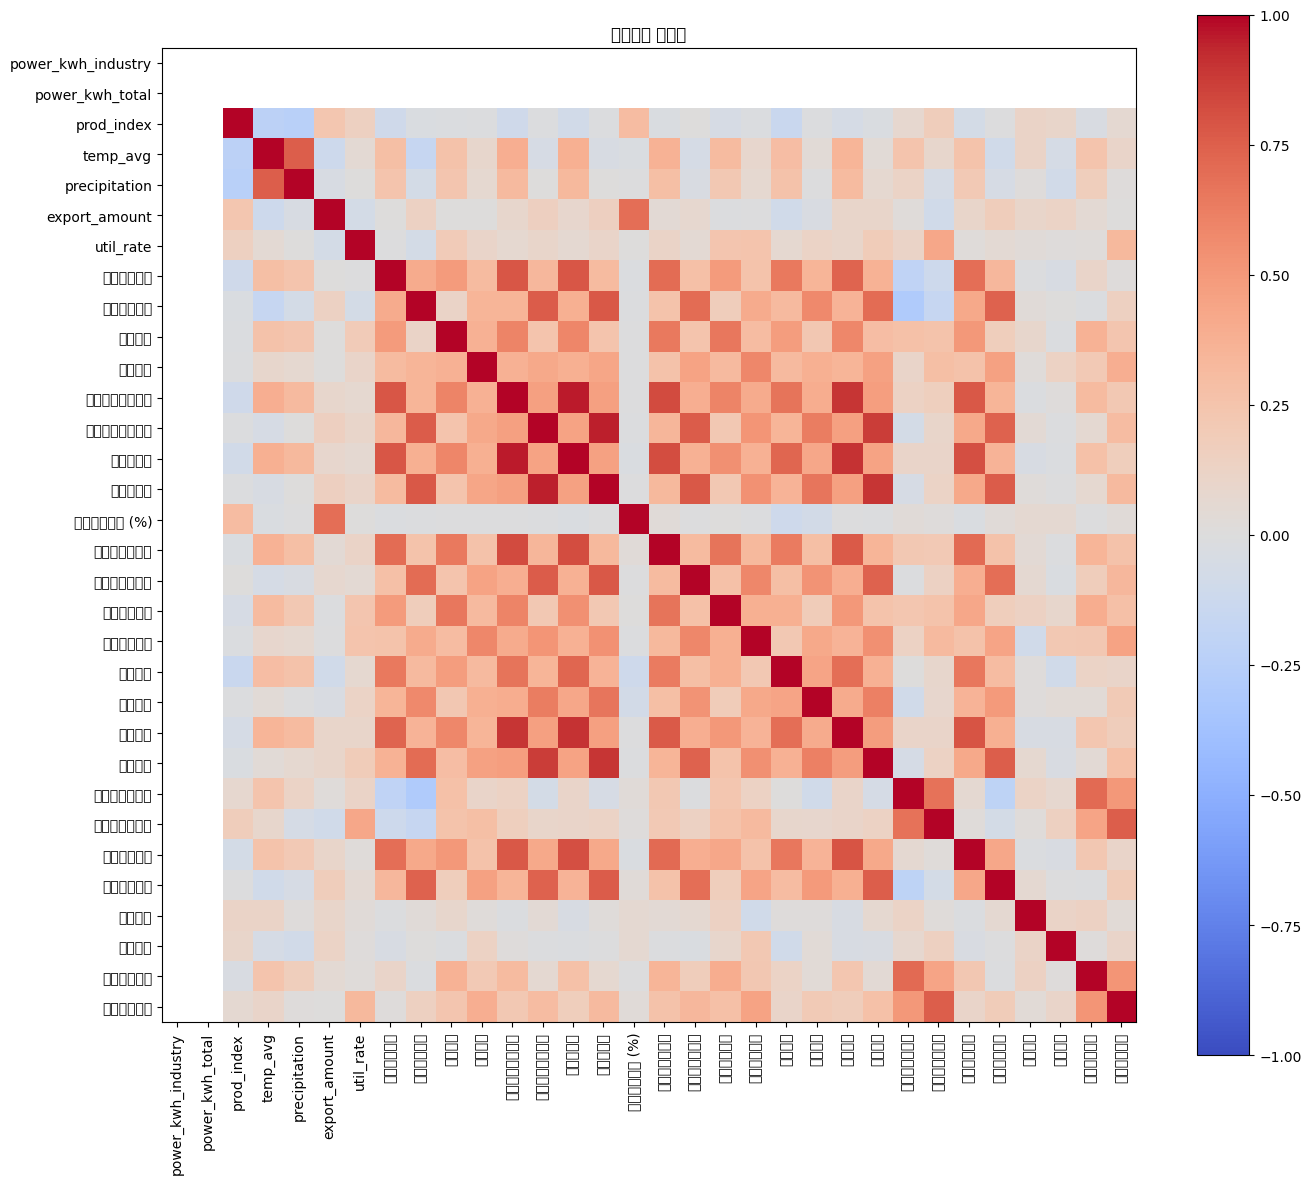

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# 2. wide-form 변환
df_wide = df.pivot_table(
    index=['month', 'region', 'power_kwh_industry', 'power_kwh_total', 'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate'],
    columns='indicator',
    values='value'
).reset_index()

# 3. 숫자형 컬럼 변환
for col in ['power_kwh_industry', 'power_kwh_total', 'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate']:
    df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')
bsi_cols = [c for c in df_wide.columns if c not in ['month', 'region']]
for c in bsi_cols:
    df_wide[c] = pd.to_numeric(df_wide[c], errors='coerce')

# 4. 상관계수 계산
corrs = df_wide.corr(numeric_only=True)

# 5. 히트맵 시각화 (matplotlib)
plt.figure(figsize=(14, 12))
plt.imshow(corrs, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corrs)), corrs.columns, rotation=90)
plt.yticks(range(len(corrs)), corrs.index)
plt.title('상관관계 히트맵')
plt.tight_layout()
plt.show()

In [79]:
import pandas as pd

df_wide = df.pivot_table(
    index=['month', 'region', 'power_kwh_industry', 'power_kwh_total', 'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate'],
    columns='indicator',
    values='value'
).reset_index()

# 숫자형 변환
num_cols = [c for c in df_wide.columns if c not in ['month','region']]
for col in num_cols:
    df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')

# 지역별로 그룹 후 상관계수
for region in df_wide['region'].unique():
    df_region = df_wide[df_wide['region']==region]
    corr = df_region.corr(numeric_only=True)
    print(f"\n[{region}] 상관계수:")
    print(corr['prod_index'].sort_values(ascending=False).head(10))


[강원] 상관계수:
indicator
prod_index    1.000000
원자재가격현황       0.175331
설비가동률전망       0.174358
부가가치비중 (%)    0.169022
제품가격현황        0.095173
원자재가격전망       0.081991
수출현황          0.041343
경상이익현황       -0.019649
util_rate    -0.033061
설비투자현황       -0.091381
Name: prod_index, dtype: float64

[경기] 상관계수:
indicator
prod_index       1.000000
부가가치비중 (%)       0.592286
수출전망             0.203906
export_amount    0.195336
util_rate        0.190006
경상이익전망           0.112834
경상이익현황           0.111943
자금사정전망           0.108762
수출현황             0.097641
설비가동률현황          0.087520
Name: prod_index, dtype: float64

[경남] 상관계수:
indicator
prod_index    1.000000
고용현황          0.508217
재고전망          0.472192
경상이익현황        0.468435
설비가동률현황       0.349484
경상이익전망        0.264333
재고현황          0.227655
매출액현황         0.160258
국내시장출하현황      0.157216
자금사정현황        0.136447
Name: prod_index, dtype: float64

[경북] 상관계수:
indicator
prod_index    1.000000
util_rate     0.622832
시황현황          0.423494
제품가격현황        0.405340
설

In [81]:
## 월별 상관계수 뽑기 (연속성/계절성 분석))
for month in sorted(df_wide['month'].unique()):
    df_month = df_wide[df_wide['month']==month]
    corr = df_month.corr(numeric_only=True)
    print(f"\n[{month}] 상관계수:")
    print(corr['prod_index'].sort_values(ascending=False).head(10))


[2020-09-01] 상관계수:
indicator
prod_index       1.000000
국내시장출하현황         0.458554
매출액현황            0.423965
export_amount    0.419298
재고현황             0.388751
원자재가격현황          0.275921
부가가치비중 (%)       0.233479
수출현황             0.218245
경상이익현황           0.184995
자금사정현황           0.168721
Name: prod_index, dtype: float64

[2020-12-01] 상관계수:
indicator
prod_index       1.000000
export_amount    0.674280
부가가치비중 (%)       0.473834
재고현황             0.332067
원자재가격현황          0.268508
설비가동률전망         -0.007314
매출액전망           -0.013597
설비투자전망          -0.053661
제품가격현황          -0.055256
국내시장출하전망        -0.057438
Name: prod_index, dtype: float64

[2021-03-01] 상관계수:
indicator
prod_index       1.000000
제품가격현황           0.253906
재고현황             0.245567
설비투자현황           0.238736
매출액현황            0.214862
고용현황             0.205576
자금사정현황           0.199711
고용전망             0.167176
export_amount    0.136581
부가가치비중 (%)       0.118499
Name: prod_index, dtype: float64

[2021-06-01] 상관계수:
indicator
p

In [82]:
# Lag(선후행) 관계 탐색
# 전력사용량 → 생산지수 lag(+1개월, +2개월)
# 예시: 전력사용량(1개월 전)이 생산지수와 상관 높은지
df_wide['power_kwh_industry_lag1'] = df_wide.groupby('region')['power_kwh_industry'].shift(1)
lag_corr = df_wide[['prod_index','power_kwh_industry_lag1']].corr(numeric_only=True)
print('1개월 lag 상관관계:', lag_corr)

# 다양한 지표/lag로 반복 가능
for lag in [1, 2, 3]:
    df_wide[f'power_kwh_industry_lag{lag}'] = df_wide.groupby('region')['power_kwh_industry'].shift(lag)
    corr = df_wide[['prod_index', f'power_kwh_industry_lag{lag}']].corr(numeric_only=True)
    print(f'{lag}개월 lag 상관계수: {corr.iloc[0,1]:.3f}')


1개월 lag 상관관계: indicator                prod_index  power_kwh_industry_lag1
indicator                                                   
prod_index                      1.0                      NaN
power_kwh_industry_lag1         NaN                      NaN
1개월 lag 상관계수: nan
2개월 lag 상관계수: nan
3개월 lag 상관계수: nan


# 모델링

In [245]:
import pandas as pd

# 파일 경로에 맞게 파일명 입력
df = pd.read_csv('병합파일/option1_with_bsi_long.csv', encoding='utf-8')
print(df.shape)
print(df.head())

(6930, 11)
        month region power_kwh_industry power_kwh_total  prod_index  temp_avg  \
0  2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
1  2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
2  2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
3  2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   
4  2020-09-01     강원       550,068,712   1,313,720,713        103.2      18.4   

   precipitation  export_amount  util_rate indicator  value  
0          225.5        1430879       73.7      시황현황   88.0  
1          225.5        1430879       73.7     매출액현황   81.0  
2          225.5        1430879       73.7  국내시장출하현황   83.0  
3          225.5        1430879       73.7      수출현황   80.0  
4          225.5        1430879       73.7      재고현황   88.0  


In [246]:
# 컬럼명 확인
print(df.columns)

Index(['month', 'region', 'power_kwh_industry', 'power_kwh_total',
       'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate',
       'indicator', 'value'],
      dtype='object')


In [247]:
# 데이터 타입 확인
print(df.dtypes)

month                  object
region                 object
power_kwh_industry     object
power_kwh_total        object
prod_index            float64
temp_avg              float64
precipitation         float64
export_amount           int64
util_rate             float64
indicator              object
value                 float64
dtype: object


In [248]:
# 결측치/ 문자형 숫자 체크
print(df.isnull().sum())

month                 0
region                0
power_kwh_industry    0
power_kwh_total       0
prod_index            0
temp_avg              0
precipitation         0
export_amount         0
util_rate             0
indicator             0
value                 0
dtype: int64


In [249]:
# 문자형 숫자 → float 변환
for col in ['power_kwh_industry', 'power_kwh_total']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [250]:
print(df.dtypes)

month                  object
region                 object
power_kwh_industry      int64
power_kwh_total         int64
prod_index            float64
temp_avg              float64
precipitation         float64
export_amount           int64
util_rate             float64
indicator              object
value                 float64
dtype: object


In [251]:
df['region_code'] = df['region'].astype('category').cat.codes

In [252]:
df_pivot = df.pivot_table(
    index=['month', 'region', 'power_kwh_industry', 'power_kwh_total', 'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate'],
    columns='indicator',
    values='value'
).reset_index()

In [253]:
# indicator별 wide 피벗
df_wide = df.pivot_table(
    index=['region', 'power_kwh_industry', 'power_kwh_total', 'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate'],
    columns='indicator',
    values='value'
).reset_index()

In [254]:
# 지역 코드로 변환
df_wide['region_code'] = df_wide['region'].astype('category').cat.codes

In [255]:
# feature/target 선택 (상관 높은 변수 위주)
features = [
    'export_amount', '부가가치비중 (%)', '매출액현황', '재고현황',
    '원자재가격현황', 'util_rate', 'power_kwh_industry', 'region_code'
]
target = 'prod_index'

In [256]:
# 결측치 제거
df_model = df_wide.dropna(subset=features + [target])
X = df_model[features]
y = df_model[target]

In [257]:
# 모델 학습 및 평가
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [258]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# 모델 학습
model = XGBRegressor(n_estimators=200)
model.fit(X_train, y_train)

# 모델 예측
y_pred = model.predict(X_test)

In [259]:
# 모델 평가
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

RMSE: 12.38, MAE: 9.48, R²: -1.0487


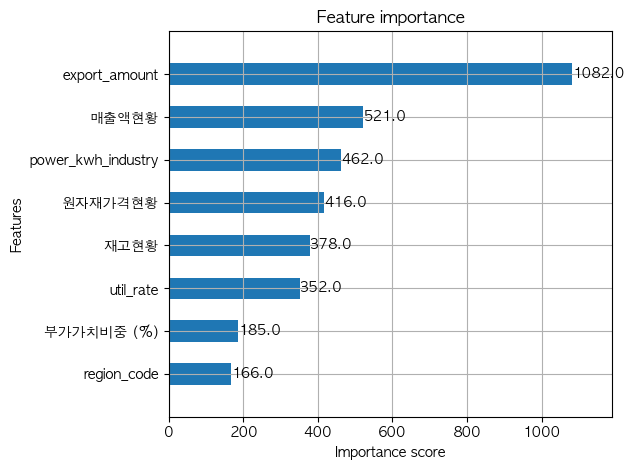

In [260]:
# 변수 중요도 확인
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, height=0.5)
plt.tight_layout()
plt.show()

---

제조업경기실사지수_지역별_전처리완료.csv + option3_merged_allregion_2015_2025.csv => 2015~2025, 세종 포함, 최신 정책분석용

In [3]:
# 파일 불러오기
import pandas as pd
df_main = pd.read_csv('병합파일/option3_merged_allregion_2015_2025.csv')
df_bsi = pd.read_csv('제조업경기실사지수_지역별_전처리완료.csv')

In [4]:
# 날짜, 지역형 통일
df_main['month'] = pd.to_datetime(df_main['month'])
df_bsi['month'] = pd.to_datetime(df_bsi['month'])
df_main['region'] = df_main['region'].astype(str)
df_bsi['region'] = df_bsi['region'].astype(str)


In [5]:
# 병합
df_merged = pd.merge(df_main, df_bsi, on=['month', 'region'], how='left')

In [6]:
# 결과 저장
df_merged.to_csv('option3_with_bsi_2015_2025.csv', index=False)

### EDA 코드

In [10]:
# 행/열 개수, 주요 컬럼명 확인
# 지역별, 지표별 데이터 커버리지
# 결측치 비율 높은 컬럼 파악

import pandas as pd

df = pd.read_csv('병합파일/option3_with_bsi_2015_2025.csv')
print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().mean())  # 결측치 비율
print(df['region'].unique())  # 지역 확인
print(df['indicator'].unique())  # BSI 지표 종류 확인

(8629, 12)
        month region power_kwh_industry  power_kwh_total  prod_index  \
0  2015-01-01     강원       585,592,815    1,617,029,201       90.726   
1  2015-01-01     경기     4,997,455,612   10,014,789,252       66.022   
2  2015-01-01     경남     1,757,495,823    3,299,662,507      118.906   
3  2015-01-01     경북     2,923,805,965    4,191,097,159      127.250   
4  2015-01-01     광주       266,092,703      776,667,026      106.893   

   temp_avg  precipitation  export_amount  util_rate_x  util_rate_y indicator  \
0      -2.4           13.3         152283         75.0         75.0       NaN   
1      -1.1           13.7        9412306         75.0         75.0       NaN   
2       2.0           29.2        5581400         75.0         75.0       NaN   
3       0.8           18.7        4025281         75.0         75.0       NaN   
4       1.7           47.2        1314089         75.0         75.0       NaN   

   value  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  
<cl

In [11]:
# 기초 통계 분석 (기술통계)
# 지표별·지역별 평균/중앙값/최댓값/최솟값 등 분포 확인
print(df.describe(include='all'))

# BSI별 기술통계
print(df.groupby('indicator')['value'].describe())

# 전력/생산지수 등 주요 컬럼도 통계 확인
main_vars = ['power_kwh_industry', 'power_kwh_total', 'prod_index', 'export_amount']
print(df[main_vars].apply(pd.to_numeric, errors='coerce').describe())

             month region power_kwh_industry power_kwh_total   prod_index  \
count         8629   8629               8629            8629  8629.000000   
unique         124     16               1984            1984          NaN   
top     2021-03-01     강원     1,748,109,289   2,724,004,606           NaN   
freq           376    567                 25              25          NaN   
mean           NaN    NaN                NaN             NaN   110.748798   
std            NaN    NaN                NaN             NaN    11.729762   
min            NaN    NaN                NaN             NaN    62.294000   
25%            NaN    NaN                NaN             NaN   103.200000   
50%            NaN    NaN                NaN             NaN   110.300000   
75%            NaN    NaN                NaN             NaN   116.500000   
max            NaN    NaN                NaN             NaN   176.600000   

           temp_avg  precipitation  export_amount  util_rate_x  util_rate_y

In [17]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. 한글 폰트 경로 찾기 (예시: 'AppleGothic' or 'Malgun Gothic')
plt.rc('font', family='AppleGothic')  # Mac
# plt.rc('font', family='Malgun Gothic')  # Windows

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 이제 이후 plot 모두 한글 정상 표시!

/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_81182/2874859732.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_month = df.groupby('month').apply(lambda x: x.isnull().mean())


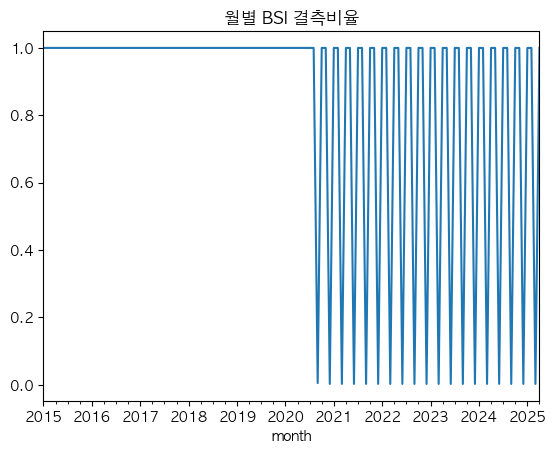

In [21]:
# 시간별 결측치 패턴 확인
import matplotlib.pyplot as plt

# 월별 결측치 개수
df['month'] = pd.to_datetime(df['month'])
missing_by_month = df.groupby('month').apply(lambda x: x.isnull().mean())
missing_by_month['value'].plot(title='월별 BSI 결측비율')
plt.show()

/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_81182/951771188.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_region = df.groupby('region').apply(lambda x: x.isnull().mean())


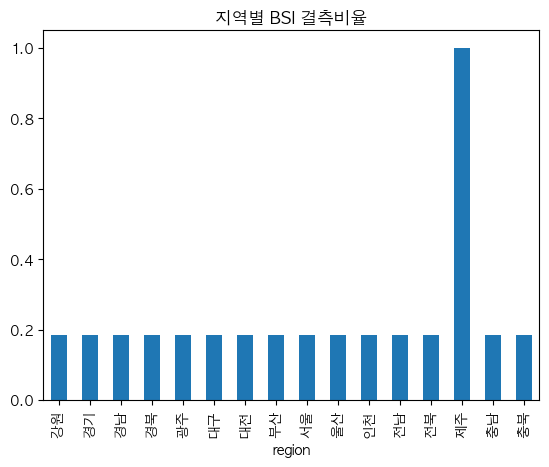

In [19]:
# 지역별 결측치 패턴 확인
missing_by_region = df.groupby('region').apply(lambda x: x.isnull().mean())
missing_by_region['value'].plot(kind='bar', title='지역별 BSI 결측비율')
plt.show()

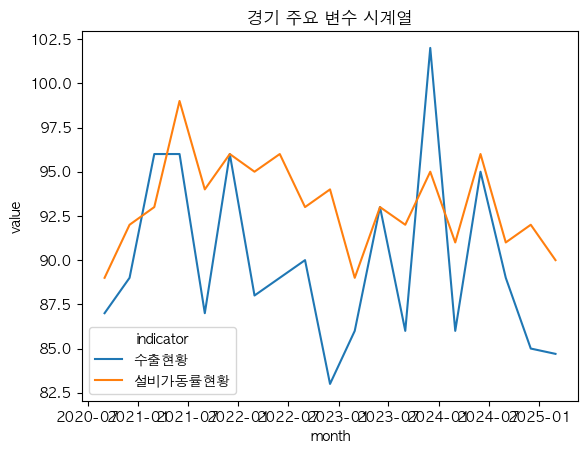

In [20]:
#  변수별 시계열 Plot
# 예: 경기 지역, prod_index & 주요 BSI만 plot
import seaborn as sns

region = '경기'
temp = df[(df['region'] == region) & (df['indicator'].isin(['prod_index', '설비가동률현황', '수출현황']))]
sns.lineplot(data=temp, x='month', y='value', hue='indicator')
plt.title(f"{region} 주요 변수 시계열")
plt.show()

In [31]:
import pandas as pd

# 데이터 불러오기
df_main = pd.read_csv('병합파일/option3_merged_allregion_2015_2025.csv', parse_dates=['month'])
df_bsi = pd.read_csv('제조업경기실사지수_지역별_전처리완료.csv', parse_dates=['month'])

# 병합
df_merged = pd.merge(df_bsi, df_main, on=['month', 'region'], how='left')

# 숫자형 컬럼 변환
num_cols = ['power_kwh_industry', 'power_kwh_total', 'prod_index', 'export_amount', 'util_rate']
for col in num_cols:
    if col in df_merged.columns:
        df_merged[col] = (
            df_merged[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.strip()
            .replace('', 'NaN')
        )
        df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# BSI indicator별 value wide-form
pivot = df_merged.pivot_table(index=['month', 'region'], columns='indicator', values='value')

# 실제 존재하는 숫자형 컬럼만 사용
exist_cols = [col for col in num_cols if col in df_merged.columns]

base_vars = (
    df_merged[['month', 'region'] + exist_cols]
    .drop_duplicates(subset=['month', 'region'])
    .set_index(['month', 'region'])
)
# join (인덱스 기준, 중복 없는 데이터라면 안전)
pivot = pivot.join(base_vars)

# 혹시 모를 숫자형 재확인
for col in num_cols:
    if col in pivot.columns:
        pivot[col] = pd.to_numeric(pivot[col], errors='coerce')

# 상관계수
corrs = pivot.corr()['prod_index'].sort_values(ascending=False)
print(corrs)

prod_index            1.000000
부가가치비중 (%)            0.300499
power_kwh_industry    0.282341
power_kwh_total       0.278983
export_amount         0.230907
원자재가격현황               0.175612
재고전망                  0.112671
재고현황                  0.098490
원자재가격전망               0.073829
제품가격현황                0.061124
설비가동률현황               0.005511
자금사정현황               -0.003594
수출현황                 -0.008061
국내시장출하현황             -0.010874
고용현황                 -0.012716
매출액현황                -0.013248
설비투자현황               -0.018804
고용전망                 -0.022101
경상이익현황               -0.029693
시황현황                 -0.030370
설비가동률전망              -0.031221
제품가격전망               -0.034871
설비투자전망               -0.053791
시황전망                 -0.054825
자금사정전망               -0.062553
매출액전망                -0.080373
국내시장출하전망             -0.100974
경상이익전망               -0.100989
수출전망                 -0.134376
Name: prod_index, dtype: float64


###  prod_index 기준 시계열 plot

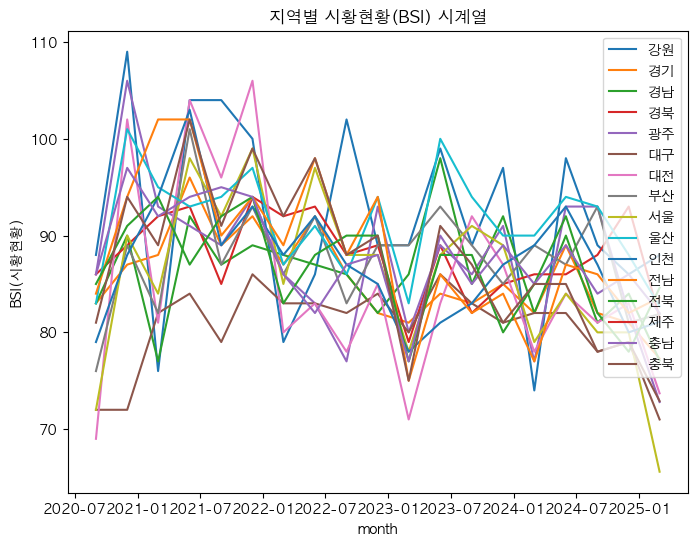

In [38]:
# BSI indicator
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for reg in df['region'].unique():
    temp = df[(df['region']==reg) & (df['indicator']=='시황현황')]
    plt.plot(temp['month'], temp['value'], label=reg)

plt.legend()
plt.title("지역별 시황현황(BSI) 시계열")
plt.xlabel("month")
plt.ylabel("BSI(시황현황)")
plt.show()

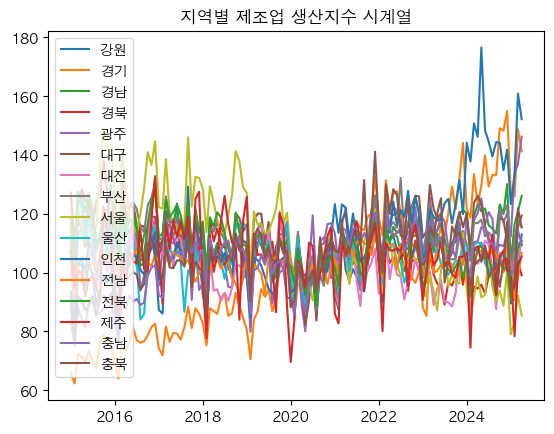

In [ ]:
# 생산지수 시계열
for reg in df['region'].unique():
    temp = df_main[df_main['region']==reg]
    plt.plot(temp['month'], temp['prod_index'], label=reg)
plt.legend()
plt.title("지역별 제조업 생산지수 시계열")
plt.show()

## 1. 제조업 생산지수 vs. BSI(시황현황) 동행성/선행성 시계열

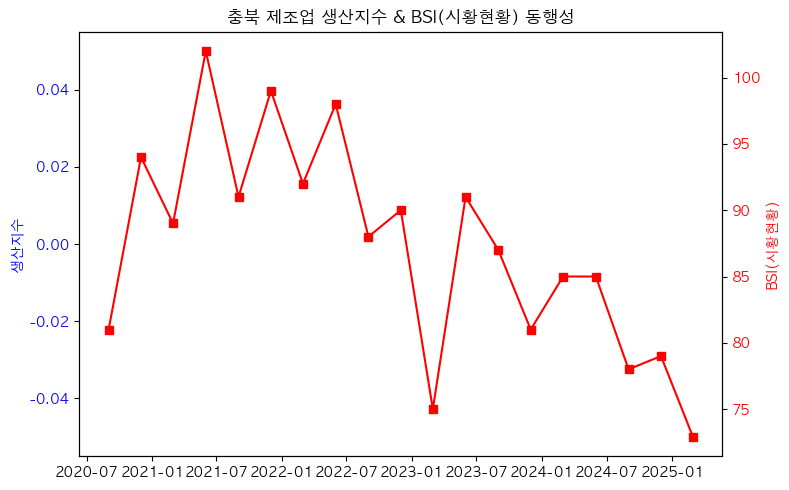

In [98]:
import matplotlib.pyplot as plt

region = '충북'  # 원하는 지역으로 변경
fig, ax1 = plt.subplots(figsize=(8,5))

# 생산지수 plot
prod = df[(df['region']==region) & (df['indicator']=='prod_index')]
ax1.plot(prod['month'], prod['value'], color='b', marker='o', label='생산지수')
ax1.set_ylabel('생산지수', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# BSI(시황현황) plot (오른쪽 y축)
ax2 = ax1.twinx()
bsi = df[(df['region']==region) & (df['indicator']=='시황현황')]
ax2.plot(bsi['month'], bsi['value'], color='r', marker='s', label='시황현황')
ax2.set_ylabel('BSI(시황현황)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title(f'{region} 제조업 생산지수 & BSI(시황현황) 동행성')
fig.tight_layout()
plt.show()

## 지역별 격차/동조성(여러 지역 겹쳐서)

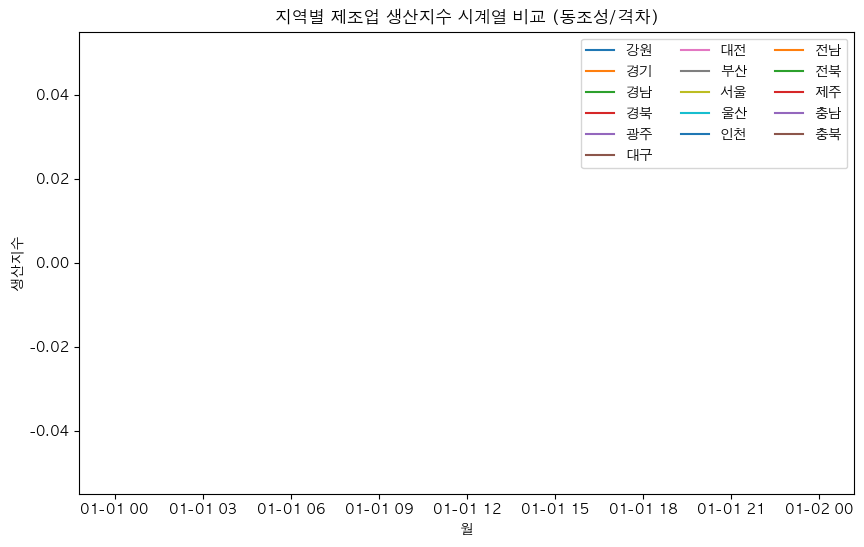

In [52]:
plt.figure(figsize=(10,6))
for reg in df['region'].unique():
    temp = df[(df['region']==reg) & (df['indicator']=='prod_index')]
    plt.plot(temp['month'], temp['value'], label=reg)
plt.legend(ncol=3)
plt.title("지역별 제조업 생산지수 시계열 비교 (동조성/격차)")
plt.xlabel("월")
plt.ylabel("생산지수")
plt.show()

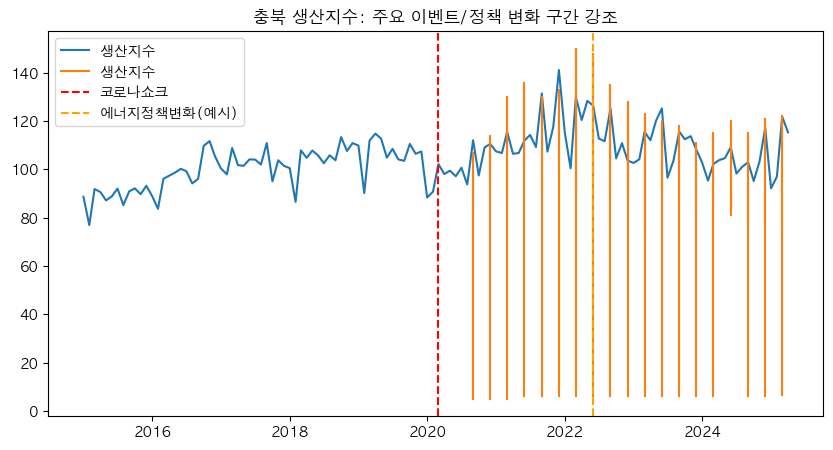

In [99]:
# 이벤트·정책 구간 강조 (예시: 코로나 직후 변화구간 강조)
plt.figure(figsize=(10,5))
prod = df[df['region']==region]
plt.plot(prod['month'], prod['prod_index'], label='생산지수')
plt.plot(prod['month'], prod['value'], label='생산지수')
plt.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', label='코로나쇼크')
plt.axvline(pd.Timestamp('2022-06-01'), color='orange', linestyle='--', label='에너지정책변화(예시)')
plt.legend()
plt.title(f"{region} 생산지수: 주요 이벤트/정책 변화 구간 강조")
plt.show()

## 산점도(Scatter) 플롯: 생산지수 vs BSI(시황현황)

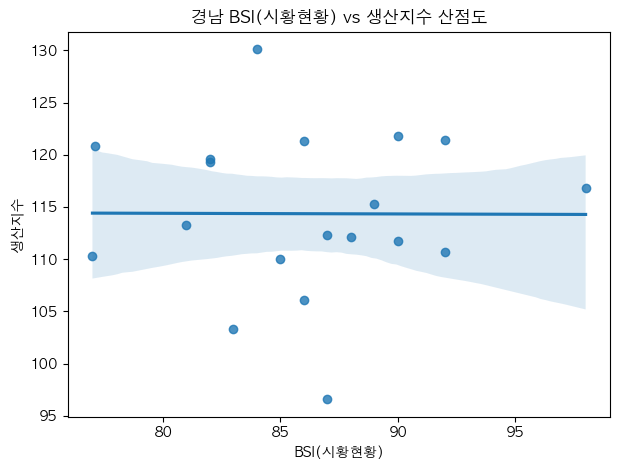

In [105]:
region = '경남'
tmp = df[df['region']==region]
pivot = tmp.pivot_table(index='month', columns='indicator', values='value')
# prod_index는 따로 불러와서 merge
prod = tmp[['month', 'prod_index']].drop_duplicates().set_index('month')
pivot = pivot.join(prod)
plt.figure(figsize=(7,5))
sns.regplot(x=pivot['시황현황'], y=pivot['prod_index'])
plt.title(f"{region} BSI(시황현황) vs 생산지수 산점도")
plt.xlabel('BSI(시황현황)')
plt.ylabel('생산지수')
plt.show()

## 머신러닝/예측모델 입력 변수 선정
- 상관계수 높은 변수 중심 파생변수 생성 <br>
→ 부가가치비중, 전력, 수출금액, BSI 주요지표(설비가동률 등) 등 예측모델용 변수 세트 제안 <br>
→ lag 변수(전월/전분기 값) 생성하여 선행성 테스트 

In [57]:
# 상관계수 높은 변수 중심으로 파생변수 & 입력 변수 생성
import pandas as pd

# 데이터 로드 (파일명 맞춰서)
df = pd.read_csv('병합파일/option3_with_bsi_2015_2025.csv', parse_dates=['month'])

# BSI 주요 indicator wide-form으로
pivot = df.pivot_table(index=['month','region'], columns='indicator', values='value')

# 중요 숫자형 변수 병합
num_cols = ['prod_index', 'power_kwh_industry', 'power_kwh_total', 'export_amount', 'util_rate', 'temp_avg', 'precipitation']
for col in num_cols:
    if col in df.columns:
        pivot[col] = df.groupby(['month','region'])[col].first()

pivot = pivot.reset_index()

# 상관계수 높은 변수들만 feature set으로
features = [
    'prod_index', '부가가치비중 (%)', 'power_kwh_industry', 'export_amount', 'util_rate',
    '시황현황', '설비가동률현황'
]

In [58]:
print(pivot.columns)
print([col for col in features if col not in pivot.columns])

Index(['month', 'region', '경상이익전망', '경상이익현황', '고용전망', '고용현황', '국내시장출하전망',
       '국내시장출하현황', '매출액전망', '매출액현황', '부가가치비중 (%)', '설비가동률전망', '설비가동률현황',
       '설비투자전망', '설비투자현황', '수출전망', '수출현황', '시황전망', '시황현황', '원자재가격전망',
       '원자재가격현황', '자금사정전망', '자금사정현황', '재고전망', '재고현황', '제품가격전망', '제품가격현황',
       'prod_index', 'power_kwh_industry', 'power_kwh_total', 'export_amount',
       'temp_avg', 'precipitation'],
      dtype='object', name='indicator')
['util_rate']


In [60]:
# 실제로 있는 컬럼만 features로 자동 필터
features = [
    'prod_index', '부가가치비중 (%)', 'power_kwh_industry', 'export_amount', 'util_rate',
    '시황현황', '설비가동률현황'
]

# pivot에 실제 존재하는 컬럼만 추출
real_features = [col for col in features if col in pivot.columns]
print("실제 사용할 feature 컬럼:", real_features)

X = pivot[real_features].dropna()
X.head()

실제 사용할 feature 컬럼: ['prod_index', '부가가치비중 (%)', 'power_kwh_industry', 'export_amount', '시황현황', '설비가동률현황']


indicator,prod_index,부가가치비중 (%),power_kwh_industry,export_amount,시황현황,설비가동률현황
0,103.2,1.0,"550,068,712",1430879,88.0,98.0
1,108.7,37.0,"5,830,713,009",84058529,83.0,89.0
2,103.3,7.0,"1,600,784,258",25754171,83.0,89.0
3,103.9,8.0,"2,357,528,894",26090784,86.0,91.0
4,110.6,2.0,"266,309,128",9951938,86.0,90.0


### 선후행(lag) 분석
- BSI → 실제 생산지수 lag 분석 <br>
→ BSI(설비가동률, 시황 등)가 1~3개월 선행/동행인지, cross-correlation plot 그려서 가장 높은 lag 탐색  <br>
→ 정책 타이밍 예측, “현장 체감” vs “실제 지표” 시차 분석

In [ ]:
#  lag(선후행) 변수 생성 및 lag 상관계수 분석
# (1) util_rate가 없으면 join
if 'util_rate' not in pivot.columns and 'util_rate' in df_merged.columns:
    util_df = df_merged[['month', 'region', 'util_rate']].drop_duplicates().set_index(['month', 'region'])
    pivot = pivot.join(util_df)
    pivot['util_rate'] = pd.to_numeric(pivot['util_rate'], errors='coerce')

# (2) 실제 존재하는 컬럼만 lag 생성
lag_cols = ['power_kwh_industry', 'export_amount', 'util_rate', '시황현황', '설비가동률현황']
lag_cols = [col for col in lag_cols if col in pivot.columns]

for lag in [1, 2, 3]:
    for col in lag_cols:
        pivot[f'{col}_lag{lag}'] = pivot.groupby('region')[col].shift(lag)

### Cross-correlation plot (lag별 시차 영향 시각화)

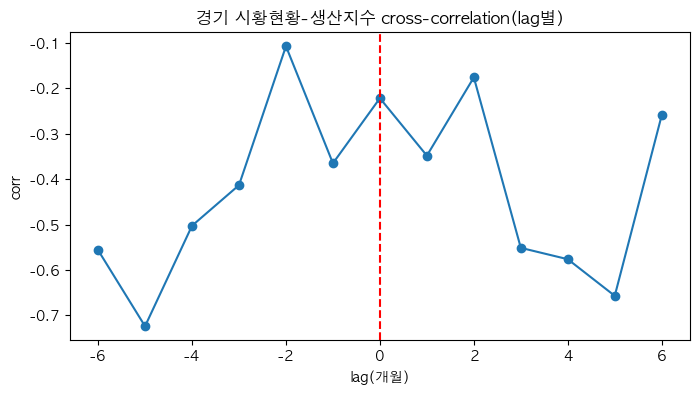

In [74]:
import matplotlib.pyplot as plt

region = '경기'
temp = pivot[pivot['region']==region]
x = temp['시황현황'].dropna()
y = temp['prod_index'].dropna()
max_lag = 6

# lag cross-correlation
cross_corr = [x.corr(y.shift(l)) for l in range(-max_lag, max_lag+1)]
plt.figure(figsize=(8,4))
plt.plot(range(-max_lag, max_lag+1), cross_corr, marker='o')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"{region} 시황현황-생산지수 cross-correlation(lag별)")
plt.xlabel('lag(개월)')
plt.ylabel('corr')
plt.show()

#### 결과 : BSI와 생산지수의 명확한 선후행 관계가 없고, 동행 또는 약한 후행 패턴만 보임.

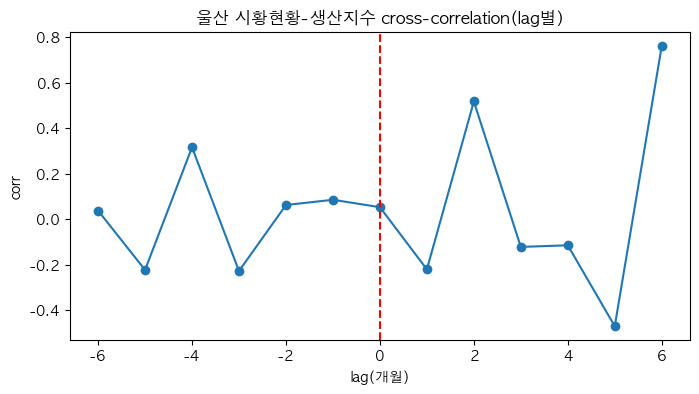

In [68]:
import matplotlib.pyplot as plt

region = '울산'
temp = pivot[pivot['region']==region]
x = temp['시황현황'].dropna()
y = temp['prod_index'].dropna()
max_lag = 6

# lag cross-correlation
cross_corr = [x.corr(y.shift(l)) for l in range(-max_lag, max_lag+1)]
plt.figure(figsize=(8,4))
plt.plot(range(-max_lag, max_lag+1), cross_corr, marker='o')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"{region} 시황현황-생산지수 cross-correlation(lag별)")
plt.xlabel('lag(개월)')
plt.ylabel('corr')
plt.show()

#### 결과 : BSI가 생산지수보다 약 5~6개월 선행하므로, BSI만으로 생산지수 변동을 미리 예측 가능

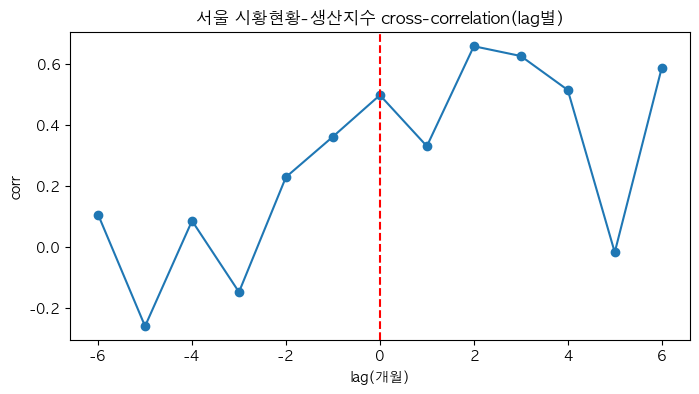

In [69]:
import matplotlib.pyplot as plt

region = '서울'
temp = pivot[pivot['region']==region]
x = temp['시황현황'].dropna()
y = temp['prod_index'].dropna()
max_lag = 6

# lag cross-correlation
cross_corr = [x.corr(y.shift(l)) for l in range(-max_lag, max_lag+1)]
plt.figure(figsize=(8,4))
plt.plot(range(-max_lag, max_lag+1), cross_corr, marker='o')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"{region} 시황현황-생산지수 cross-correlation(lag별)")
plt.xlabel('lag(개월)')
plt.ylabel('corr')
plt.show()

### 결과 : BSI가 약 2~3개월 앞서 변동하며, 서울의 생산지수 조기 예측에 활용할 수 있음.

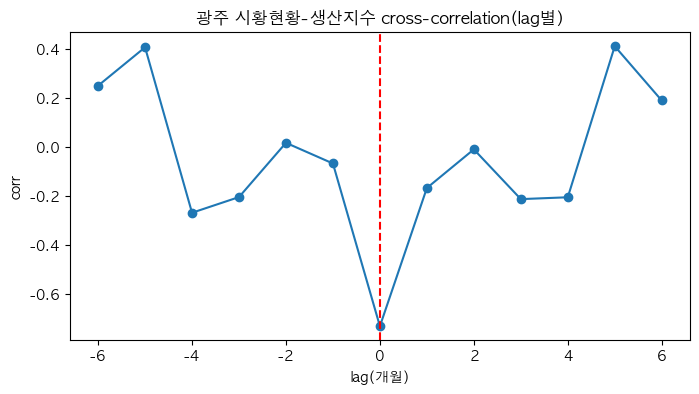

In [84]:
import matplotlib.pyplot as plt

region = '광주'
temp = pivot[pivot['region']==region]
x = temp['시황현황'].dropna()
y = temp['prod_index'].dropna()
max_lag = 6

# lag cross-correlation
cross_corr = [x.corr(y.shift(l)) for l in range(-max_lag, max_lag+1)]
plt.figure(figsize=(8,4))
plt.plot(range(-max_lag, max_lag+1), cross_corr, marker='o')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"{region} 시황현황-생산지수 cross-correlation(lag별)")
plt.xlabel('lag(개월)')
plt.ylabel('corr')
plt.show()

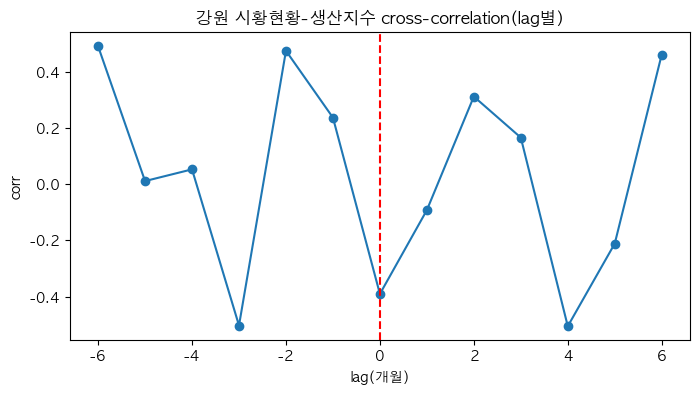

In [72]:
import matplotlib.pyplot as plt

region = '강원'
temp = pivot[pivot['region']==region]
x = temp['시황현황'].dropna()
y = temp['prod_index'].dropna()
max_lag = 6

# lag cross-correlation
cross_corr = [x.corr(y.shift(l)) for l in range(-max_lag, max_lag+1)]
plt.figure(figsize=(8,4))
plt.plot(range(-max_lag, max_lag+1), cross_corr, marker='o')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"{region} 시황현황-생산지수 cross-correlation(lag별)")
plt.xlabel('lag(개월)')
plt.ylabel('corr')
plt.show()

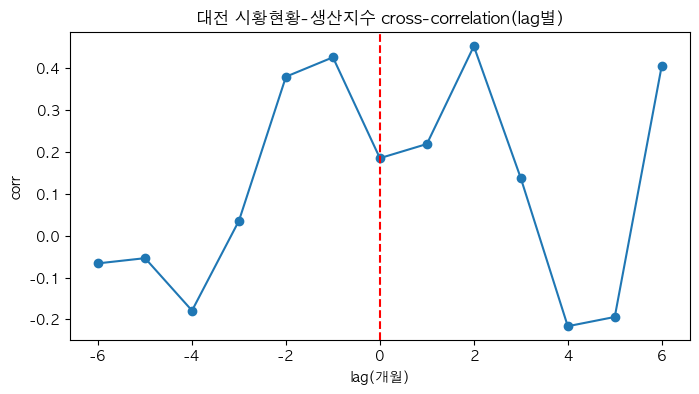

In [85]:
import matplotlib.pyplot as plt

region = '대전'
temp = pivot[pivot['region']==region]
x = temp['시황현황'].dropna()
y = temp['prod_index'].dropna()
max_lag = 6

# lag cross-correlation
cross_corr = [x.corr(y.shift(l)) for l in range(-max_lag, max_lag+1)]
plt.figure(figsize=(8,4))
plt.plot(range(-max_lag, max_lag+1), cross_corr, marker='o')
plt.axvline(0, color='red', linestyle='--')
plt.title(f"{region} 시황현황-생산지수 cross-correlation(lag별)")
plt.xlabel('lag(개월)')
plt.ylabel('corr')
plt.show()

### 분석 결과
- **지역별로 BSI와 생산지수의 상관성이 최대가 되는 lag(시차)** 가 다르게 나타나는 것을 확인할 수 있었습니다.
- 예를 들어, 서울/울산/대구 등 일부 지역에서는 BSI가 생산지수에 대해 **선행(1~3개월 먼저 움직임)** 하거나, 반대로 경기와 같은 지역은 동행 또는 후행하는 양상이 나타났습니다.
- BSI와 생산지수의 동행 또는 1~2개월 선행 패턴이 있지만, 지역마다 차이가 큼.

이런 차이는 현장의 경기 체감이 실제 생산활동에 반영되는 시간적 차이, 또는 정책효과가 지표에 나타나는 속도의 차이로 해석할 수 있습니다.

---

## 머신러닝/예측모델 입력 변수 선정

In [75]:
# [1] 주요 변수 선정: 상관계수 높은 변수 위주로 feature set 구성
# 실제 사용할 feature 컬럼
features = ['부가가치비중 (%)', 'power_kwh_industry', 'export_amount', '시황현황', '설비가동률현황']

# 데이터 불러오기 (wide format: pivot 테이블 형태로 만들어져 있어야 함)
import pandas as pd

# (이미 wide-form으로 되어 있다면 이 과정은 생략)
# 예시: df = pd.read_csv('머신러닝_데이터셋.csv', parse_dates=['month'])

# 결측치 행 제거
X = pivot[features + ['prod_index']].dropna()

# 데이터 확인
print(X.head())

indicator  부가가치비중 (%) power_kwh_industry  export_amount  시황현황  설비가동률현황  \
0                 1.0       550,068,712         1430879  88.0     98.0   
1                37.0     5,830,713,009        84058529  83.0     89.0   
2                 7.0     1,600,784,258        25754171  83.0     89.0   
3                 8.0     2,357,528,894        26090784  86.0     91.0   
4                 2.0       266,309,128         9951938  86.0     90.0   

indicator  prod_index  
0               103.2  
1               108.7  
2               103.3  
3               103.9  
4               110.6  


| 변수                 | lag1 상관계수 | lag2 상관계수 | lag3 상관계수 | 해석 요약                                     |
|---------------------|:------------:|:------------:|:------------:|:----------------------------------------------|
| 부가가치비중 (%)     |    0.303     |    0.290     |    0.319     | 생산지수와 **일관된 양의 상관관계**, 선후행 효과 O   |
| power_kwh_industry  |    0.285     |    0.274     |    0.282     | 산업용 전력사용량, 생산지수 예측 신호로 유의미       |
| export_amount       |    0.303     |    0.247     |    0.093     | 수출금액도 **양의 상관관계**, lag 늘수록 감소         |
| 시황현황            |   -0.002     |    0.068     |   -0.064     | 심리지표(시황현황), 상관 약하거나 거의 없음          |
| 설비가동률현황       |    0.018     |    0.030     |   -0.093     | 설비가동률, 영향 거의 없음                        |

## 선후행(lag) 분석

In [80]:
pivot_reset = pivot.reset_index()

# 숫자형 컬럼(실제 존재하는 것만) 변환: 콤마/공백 제거 후 float 변환
num_cols = ['power_kwh_industry', 'power_kwh_total', 'prod_index', 'export_amount', 'util_rate']
for col in num_cols:
    if col in pivot_reset.columns:
        pivot_reset[col] = (
            pivot_reset[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.strip()
        )
        pivot_reset[col] = pd.to_numeric(pivot_reset[col], errors='coerce')

# (이후 lag 변수 생성~)
for lag in [1, 2, 3]:
    for col in features:
        pivot_reset[f'{col}_lag{lag}'] = (
            pivot_reset.groupby('region')[col].shift(lag)
        )

pivot_reset = pivot_reset.set_index(['month', 'region'])

for lag in [1, 2, 3]:
    print(f"\n=== lag {lag}개월 ===")
    for col in features:
        colname = f'{col}_lag{lag}'
        subdf = pivot_reset[[colname, 'prod_index']].dropna()
        # lag 파생 컬럼도 float 변환(안전장치)
        subdf[colname] = pd.to_numeric(subdf[colname], errors='coerce')
        subdf['prod_index'] = pd.to_numeric(subdf['prod_index'], errors='coerce')
        corr = subdf[colname].corr(subdf['prod_index'])
        print(f"{colname} vs prod_index: {corr:.3f}")


=== lag 1개월 ===
부가가치비중 (%)_lag1 vs prod_index: 0.303
power_kwh_industry_lag1 vs prod_index: 0.285
export_amount_lag1 vs prod_index: 0.303
시황현황_lag1 vs prod_index: -0.002
설비가동률현황_lag1 vs prod_index: 0.018

=== lag 2개월 ===
부가가치비중 (%)_lag2 vs prod_index: 0.290
power_kwh_industry_lag2 vs prod_index: 0.274
export_amount_lag2 vs prod_index: 0.247
시황현황_lag2 vs prod_index: 0.068
설비가동률현황_lag2 vs prod_index: 0.030

=== lag 3개월 ===
부가가치비중 (%)_lag3 vs prod_index: 0.319
power_kwh_industry_lag3 vs prod_index: 0.282
export_amount_lag3 vs prod_index: 0.093
시황현황_lag3 vs prod_index: -0.064
설비가동률현황_lag3 vs prod_index: -0.093


#### 생산지수(prod_index)와 시차별(lag) 주요 변수 상관관계
| 변수명                   | lag 1개월 | lag 2개월 | lag 3개월 | 해석/특징                                                         |
|-------------------------|:---------:|:---------:|:---------:|-------------------------------------------------------------------|
| 부가가치비중 (%)         |   0.303   |   0.290   |   0.319   | 전월~3개월 전 부가가치가 높으면 생산지수도 높아지는 경향(강한 양의 상관)    |
| power_kwh_industry      |   0.285   |   0.274   |   0.282   | 산업용 전력사용량도 생산지수와 꾸준히 높은 상관(실제 산업 활동량 반영)     |
| export_amount           |   0.303   |   0.247   |   0.093   | 1~2개월 전 수출이 많으면 생산지수에 긍정 영향, 3개월은 약해짐            |
| 시황현황                 |  -0.002   |   0.068   |  -0.064   | BSI 시황은 생산지수와 직접적 연관 거의 없음(심리지표 한계)               |
| 설비가동률현황            |   0.018   |   0.030   |  -0.093   | 설비가동률 역시 실제 생산지수와는 약한 상관                             |

## 결론
- 부가가치비중, 산업용 전력사용량, 수출금액이 lag 1~3개월에서 생산지수와 상관이 가장 높음 → 예측력 있는 주요 변수
- BSI 시황현황, 설비가동률현황은 생산지수와 동조성이 약함 → 참고 보조지표로만 활용
- 사용자에게는 “부가가치와 전력사용량이 증가하면 생산지수도 같이 오른다“는 인사이트로 제공 가능

---

# 모델링 맛보기

In [129]:
# 가상환경에서 설치할 때는 반드시 brew로 libomp 먼저 설치하고
!brew install libomp


==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
backgroundremover          gemini-cli                 yaml2json
==> New Casks
font-tenderness            msgfiler                   spacesaver

You have 9 outdated formulae and 1 outdated cask installed.

==> Downloading https://ghcr.io/v2/homebrew/core/libomp/manifests/20.1.7
######################################################################### 100.0%
==> Fetching libomp
==> Downloading https://ghcr.io/v2/homebrew/core/libomp/blobs/sha256:a93e7a009eb
######################################################################### 100.0%
==> Pouring libomp--20.1.7.arm64_sonoma.bottle.tar.gz
==> Caveats
libomp is keg-only, which means it was not symlinked into /opt/homebrew,
because it can override GCC heade

In [131]:
!brew info libomp

==> libomp: stable 20.1.7 (bottled) [keg-only]
LLVM's OpenMP runtime library
https://openmp.llvm.org/
Installed
/opt/homebrew/Cellar/libomp/20.1.7 (9 files, 1.7MB)
  Poured from bottle using the formulae.brew.sh API on 2025-06-26 at 20:54:37
From: https://github.com/Homebrew/homebrew-core/blob/HEAD/Formula/lib/libomp.rb
License: MIT
==> Dependencies
Build: cmake ✘, lit ✘
==> Caveats
libomp is keg-only, which means it was not symlinked into /opt/homebrew,
because it can override GCC headers and result in broken builds.

For compilers to find libomp you may need to set:
  export LDFLAGS="-L/opt/homebrew/opt/libomp/lib"
  export CPPFLAGS="-I/opt/homebrew/opt/libomp/include"
==> Analytics
install: 59,396 (30 days), 189,138 (90 days), 655,493 (365 days)
install-on-request: 16,620 (30 days), 48,722 (90 days), 148,684 (365 days)
build-error: 6 (30 days)


In [192]:
import pandas as pd
import xgboost as xgb # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [264]:
# 데이터 불러오기
df = pd.read_csv('병합파일/option3_with_bsi_2015_2025.csv')  # 실제 파일명으로 바꿔줘

In [265]:
# lag 변수 만들 대상 컬럼 리스트
lag_cols = ['power_kwh_industry', 'export_amount', 'util_rate_x', 'util_rate_y']

In [266]:
# 지역별로 1~3개월 lag 변수 생성
for col in lag_cols:
    for l in [1, 2, 3]:
        df[f"{col}_lag{l}"] = df.groupby('region')[col].shift(l)

In [267]:
# 지역 인코딩
df['region_code'] = df['region'].astype('category').cat.codes

In [268]:
#  feature & target 컬럼 이름 리스트 지정
features = [
    'power_kwh_industry_lag1',
    'export_amount_lag1',
    'util_rate_x_lag1',
    'util_rate_y_lag1',
    'region_code'
]
target = 'prod_index'

In [269]:
print(df[features + [target]].isnull().sum())

power_kwh_industry_lag1    16
export_amount_lag1         16
util_rate_x_lag1           16
util_rate_y_lag1           16
region_code                 0
prod_index                  0
dtype: int64


In [270]:
print(df[features + [target]].head(10))

  power_kwh_industry_lag1  export_amount_lag1  util_rate_x_lag1  \
0                     NaN                 NaN               NaN   
1                     NaN                 NaN               NaN   
2                     NaN                 NaN               NaN   
3                     NaN                 NaN               NaN   
4                     NaN                 NaN               NaN   
5                     NaN                 NaN               NaN   
6                     NaN                 NaN               NaN   
7                     NaN                 NaN               NaN   
8                     NaN                 NaN               NaN   
9                     NaN                 NaN               NaN   

   util_rate_y_lag1  region_code  prod_index  
0               NaN            0      90.726  
1               NaN            1      66.022  
2               NaN            2     118.906  
3               NaN            3     127.250  
4               NaN        

In [271]:
print(df[features + [target]][df['power_kwh_industry_lag1'].notnull()].head(10))

   power_kwh_industry_lag1  export_amount_lag1  util_rate_x_lag1  \
16            585,592,815             152283.0              75.0   
17          4,997,455,612            9412306.0              75.0   
18          1,757,495,823            5581400.0              75.0   
19          2,923,805,965            4025281.0              75.0   
20            266,092,703            1314089.0              75.0   
21            602,778,084             609500.0              75.0   
22            286,480,493             408262.0              75.0   
23            723,831,996            1281646.0              75.0   
24            462,259,628            4765699.0              75.0   
25          2,248,509,343            5533531.0              75.0   

    util_rate_y_lag1  region_code  prod_index  
16              75.0            0      84.073  
17              75.0            1      62.294  
18              75.0            2     104.994  
19              75.0            3     109.988  
20         

In [272]:
# 콤마 제거 + 숫자 변환
for col in ['power_kwh_industry', 'export_amount']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    for l in [1]:
        df[f'{col}_lag{l}'] = df.groupby('region')[col].shift(l)
        # lag 변수도 콤마 제거
        df[f'{col}_lag{l}'] = df[f'{col}_lag{l}'].astype(str).str.replace(',', '', regex=False)

# 나머지 lag 변수도 수치형 강제 변환 (util_rate_x, util_rate_y 등)
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [273]:
df_model = df.dropna(subset=features + [target])
X = df_model[features]
y = df_model[target]
print(X.shape, y.shape)  # 0줄 아니면 OK

(8613, 5) (8613,)


In [274]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [275]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [276]:
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

In [277]:
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"R²(결정계수): {r2:.4f}")

RMSE: 14.06, MAE: 10.12
R²(결정계수): 0.2297


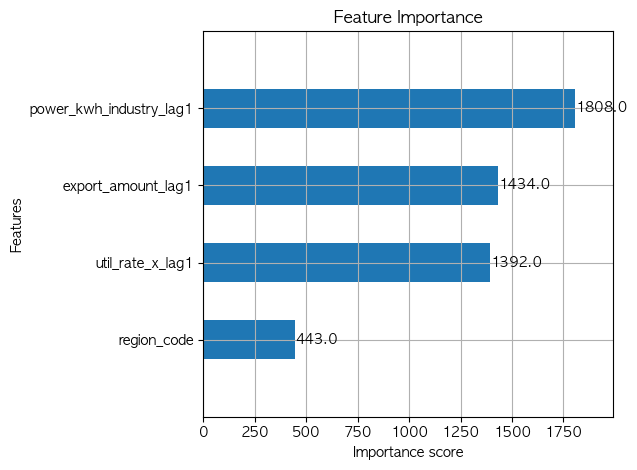

In [278]:
# 중요 변수 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, height=0.5)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [212]:
# 실제값/예측값 비교 표 만들기
# 실제값, 예측값, 오차(실제-예측) 정리
result_df = X_test.copy()
result_df['실제값'] = y_test.values
result_df['예측값'] = y_pred
result_df['예측오차'] = result_df['실제값'] - result_df['예측값']

# 앞 10개만 샘플로 보기
print(result_df[['실제값', '예측값', '예측오차']].head(10))

        실제값         예측값      예측오차
6906  102.3  102.614616 -0.314616
6907  102.3  102.614616 -0.314616
6908  102.3  102.614616 -0.314616
6909  102.3  102.614616 -0.314616
6910  102.3  102.614616 -0.314616
6911  102.3  102.614616 -0.314616
6912  102.3  102.614616 -0.314616
6913  102.3  102.614616 -0.314616
6914  102.3  102.614616 -0.314616
6915  102.3  102.614616 -0.314616


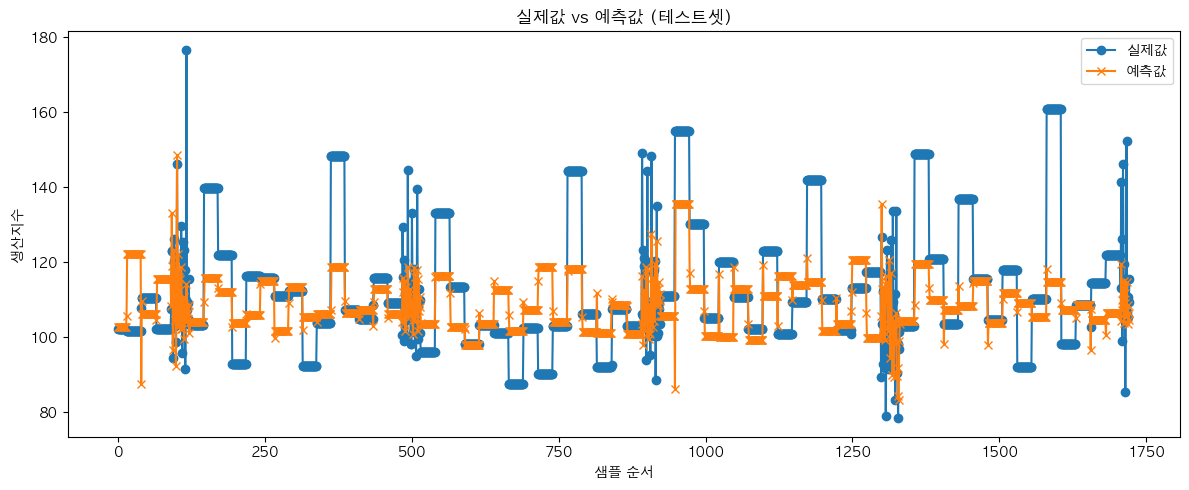

In [213]:
# 실제값 vs 예측값 선그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(result_df['실제값'].values, label='실제값', marker='o')
plt.plot(result_df['예측값'].values, label='예측값', marker='x')
plt.legend()
plt.title("실제값 vs 예측값 (테스트셋)")
plt.xlabel("샘플 순서")
plt.ylabel("생산지수")
plt.tight_layout()
plt.show()

In [214]:
# 결정계수 점수
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R²(결정계수): {r2:.4f}")

R²(결정계수): 0.2297


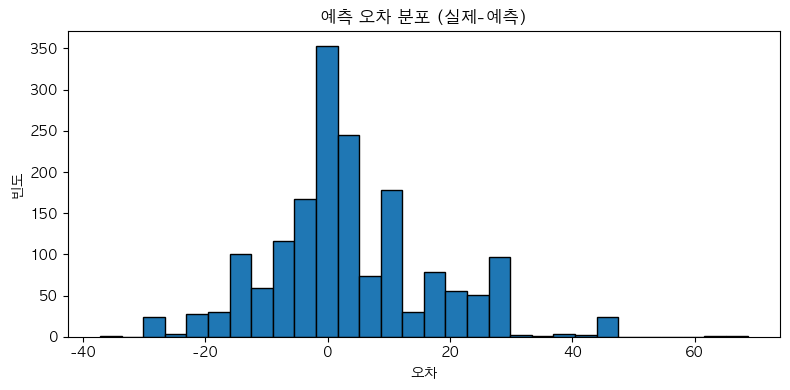

In [217]:
# 예측 오차 분포(히스토그램)
plt.figure(figsize=(8,4))
plt.hist(result_df['예측오차'], bins=30, edgecolor='k')
plt.title("예측 오차 분포 (실제-예측)")
plt.xlabel("오차")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

# 정상성 검사

Note: you may need to restart the kernel to use updated packages.


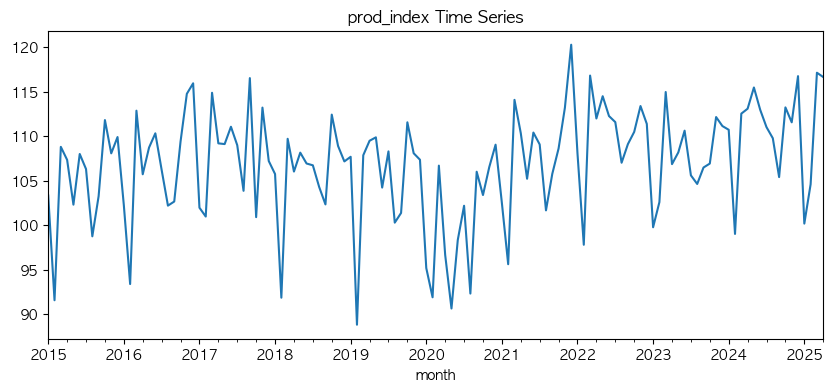

option3 데이터의 정상성 검정 결과:
ADF Test Statistic: -1.2384052123222544
p-value: 0.6568605149678646
Critical Values:
   1%: -3.4901313156261384
   5%: -2.8877122815688776
   10%: -2.5807296460459184
❌ 정상성 없음 (p ≥ 0.05) → 차분 또는 변환 필요


In [18]:
%pip install statsmodels

import pandas as pd
from statsmodels.tsa.stattools import adfuller # type: ignore
import matplotlib.pyplot as plt

# 데이터 불러오기 (예시)
df = pd.read_csv('병합파일/option3_with_bsi_2015_2025.csv')  # 파일명에 맞게 수정

# 날짜 형식 처리 및 정렬
df['month'] = pd.to_datetime(df['month'])
df.sort_values('month', inplace=True)

# 분석할 변수 선택 (예: 생산지수)
target_col = 'prod_index'

# 월별 전국 평균으로 시계열 구성
ts = df.groupby('month')[target_col].mean()

# 시계열 플롯 확인
ts.plot(title=f'{target_col} Time Series', figsize=(10,4))
plt.show()

# ADF Test 실행
result = adfuller(ts.dropna())

# 결과 출력
print("option3 데이터의 정상성 검정 결과:")
print(f"ADF Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# 해석 기준
if result[1] < 0.05:
    print("✅ 정상성 있음 (p < 0.05)")
else:
    print("❌ 정상성 없음 (p ≥ 0.05) → 차분 또는 변환 필요")

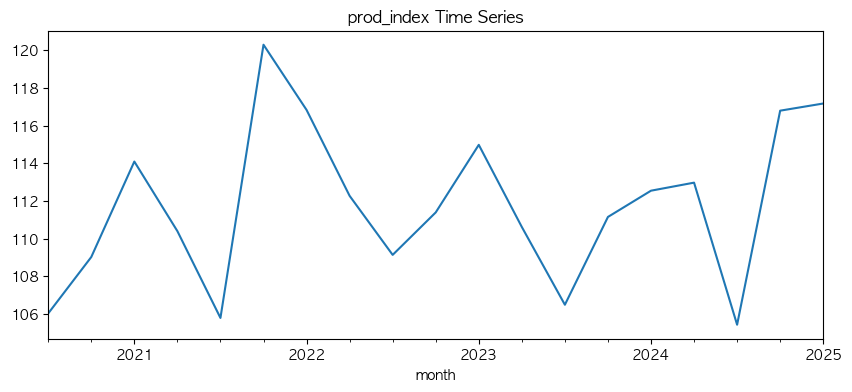

option1 데이터의 정상성 검정 결과
ADF Test Statistic: -4.514738602949736
p-value: 0.0001849270948990445
Critical Values:
   1%: -3.889265672705068
   5%: -3.0543579727254224
   10%: -2.66698384083045
✅ 정상성 있음 (p < 0.05)


In [19]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller # type: ignore
import matplotlib.pyplot as plt

# 데이터 불러오기 (예시)
df = pd.read_csv('병합파일/option1_with_bsi_long.csv')  # 파일명에 맞게 수정

# 날짜 형식 처리 및 정렬
df['month'] = pd.to_datetime(df['month'])
df.sort_values('month', inplace=True)

# 분석할 변수 선택 (예: 생산지수)
target_col = 'prod_index'

# 월별 전국 평균으로 시계열 구성
ts = df.groupby('month')[target_col].mean()

# 시계열 플롯 확인
ts.plot(title=f'{target_col} Time Series', figsize=(10,4))
plt.show()

# ADF Test 실행
result = adfuller(ts.dropna())

# 결과 출력
print("option1 데이터의 정상성 검정 결과")
print(f"ADF Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# 해석 기준
if result[1] < 0.05:
    print("✅ 정상성 있음 (p < 0.05)")
else:
    print("❌ 정상성 없음 (p ≥ 0.05) → 차분 또는 변환 필요")

### 차분 진행

In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('병합파일/option3_with_bsi_2015_2025.csv')

# 문자열 숫자형 처리
for col in ['power_kwh_industry', 'export_amount']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).astype(float)

# lag 변수 생성
lag_cols = ['power_kwh_industry', 'export_amount', 'util_rate_x', 'util_rate_y']
for col in lag_cols:
    for l in [1, 2, 3]:
        df[f"{col}_lag{l}"] = df.groupby('region')[col].shift(l)

# 지역 코드
df['region_code'] = df['region'].astype('category').cat.codes

# ✅ 타깃 차분 처리 (지역별)
df['prod_index_diff'] = df.groupby('region')['prod_index'].diff()

# 학습용 피처
features = [
    'power_kwh_industry_lag1',
    'export_amount_lag1',
    'util_rate_x_lag1',
    'util_rate_y_lag1',
    'region_code'
]
target = 'prod_index_diff'

# 결측 제거
df_model = df.dropna(subset=features + [target])
X = df_model[features]
y = df_model[target]

# train/test 분리 (시계열 고려 → shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 학습
model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Option3 차분 예측 결과 - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

Option3 차분 예측 결과 - RMSE: 5.61, MAE: 4.16, R²: -1.6859


---

### “option1이 구조만 정비되면 option3보다 성능이 좋을 수 있을까?”

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 불러오기
df = pd.read_csv('병합파일/option1_with_bsi_long.csv', encoding='utf-8')

In [2]:
# 문자열 숫자 처리
df['power_kwh_industry'] = df['power_kwh_industry'].str.replace(',', '', regex=False).astype(float)
df['export_amount'] = df['export_amount'].astype(float)


In [3]:

# wide-format 변환 (BSI indicator를 피벗)
df_pivoted = df.pivot_table(
    index=['month', 'region', 'prod_index', 'power_kwh_industry', 'export_amount', 'util_rate'],
    columns='indicator',
    values='value',
    aggfunc='first'
).reset_index()
df_pivoted.columns.name = None

In [4]:
# lag 변수 생성 (지역별 기준)
lag_targets = ['power_kwh_industry', 'export_amount', 'util_rate']
for col in lag_targets:
    df_pivoted[f'{col}_lag1'] = df_pivoted.groupby('region')[col].shift(1)

In [5]:
# 지역 인코딩
df_pivoted['region_code'] = df_pivoted['region'].astype('category').cat.codes

In [6]:
# 모델 피처 & 타깃 설정
features = ['power_kwh_industry_lag1', 'export_amount_lag1', 'util_rate_lag1', 'region_code']
target = 'prod_index'


In [7]:
# 결측 제거
df_model = df_pivoted.dropna(subset=features + [target])
X = df_model[features]
y = df_model[target]

In [8]:
# 시계열 특성 고려한 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
# 모델 학습
model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [11]:
# 예측 및 성능 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"option1 기반 성능\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

option1 기반 성능
RMSE: 11.89, MAE: 8.76, R²: 0.4840


In [14]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우: 맑은 고딕
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')  # 맥OS: 애플고딕
else:
    plt.rc('font', family='NanumGothic')  # 리눅스: 나눔고딕 (설치 필요할 수 있음)

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

In [15]:
# 실제값 예측값 비교
import matplotlib.pyplot as plt
import pandas as pd

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '실제값': y_test.values,
    '예측값': y_pred
}).reset_index(drop=True)

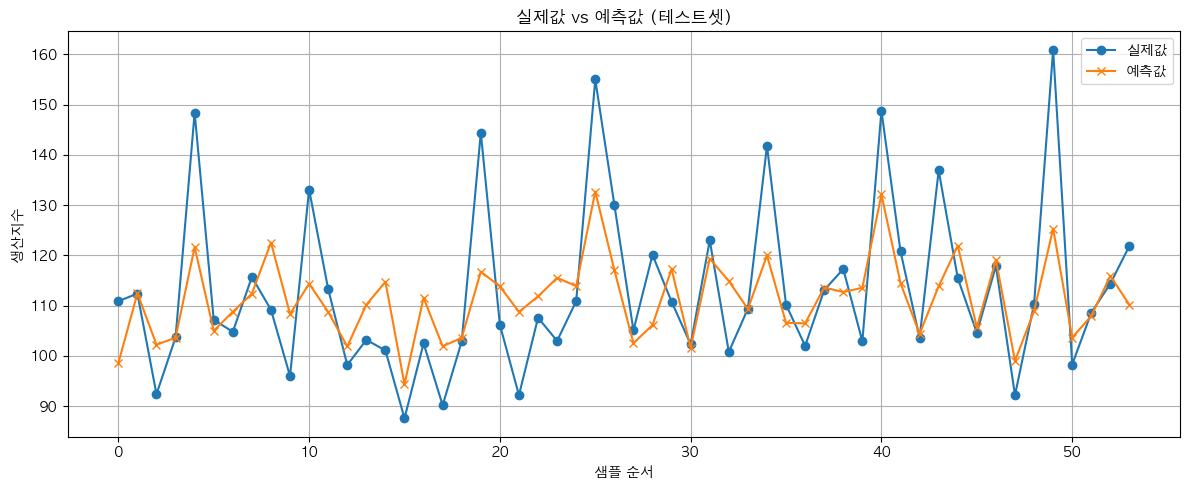

In [16]:
# 선그래프 시각화
plt.figure(figsize=(12, 5))
plt.plot(result_df['실제값'], label='실제값', marker='o')
plt.plot(result_df['예측값'], label='예측값', marker='x')
plt.title("실제값 vs 예측값 (테스트셋)")
plt.xlabel("샘플 순서")
plt.ylabel("생산지수")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

---

# Option1에 대해서 딥러닝 Test
## LSTM 모델 사용

In [2]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 38.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 📌 1. 데이터 준비
df = pd.read_csv('병합파일/option1_with_bsi_long.csv', encoding='utf-8')
df['region_code'] = df['region'].astype('category').cat.codes


In [2]:
# 쉼표 제거 및 숫자형 변환
for col in ['power_kwh_industry', 'export_amount']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [3]:
#  lag 변수 생성
lag_cols = ['power_kwh_industry', 'export_amount', 'util_rate']
for col in lag_cols:
    df[f'{col}_lag1'] = df.groupby('region')[col].shift(1)

In [4]:
# lag 변수도 수치형으로 강제 변환
for col in ['power_kwh_industry_lag1', 'export_amount_lag1', 'util_rate_lag1']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [5]:
features = ['power_kwh_industry_lag1', 'export_amount_lag1', 'util_rate_lag1', 'region_code']
target = 'prod_index'
df.dropna(subset=features + [target], inplace=True)

In [6]:
X = df[features].values
y = df[target].values.reshape(-1, 1)

In [7]:
# 정규화
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [8]:
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [9]:
# 시계열 입력 형태로 재구성 (sequence_length=3)
sequence_length = 6 # 원하는 개월짜리 흐름보기
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

In [72]:
# 시계열 입력 형태로 재구성 (sequence_length=3)
sequence_length = 6 # 6 개월짜리 흐름보기
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

In [73]:
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [74]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [75]:
# PyTorch 텐서 변환
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

In [76]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=32)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [77]:
# 학습
for epoch in range(100):
    model.train()
    output = model(X_train_t)
    loss = loss_fn(output, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 0.1394
Epoch 10 | Loss: 0.0249
Epoch 20 | Loss: 0.0185
Epoch 30 | Loss: 0.0166
Epoch 40 | Loss: 0.0160
Epoch 50 | Loss: 0.0159
Epoch 60 | Loss: 0.0159
Epoch 70 | Loss: 0.0158
Epoch 80 | Loss: 0.0158
Epoch 90 | Loss: 0.0158


In [78]:
#  예측 및 성능
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)  # 직접 루트 적용
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("LSTM 모델 성능")
print("{}개월짜리 흐름 예측 결과".format(sequence_length))
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

LSTM 모델 성능
6개월짜리 흐름 예측 결과
RMSE: 15.55, MAE: 11.46, R²: 0.0930


[ 결과 ]
- 예측력 낮음: R²가 0.1 미만으로 예측력이 매우 낮은 수준
- XGBoost (R²=0.484) 대비 성능 크게 저하
- 오히려 단순 회귀보다 못한 결과 → 과적합 우려는 적으나, 모델 표현력 부족 or 학습 실패 가능성 있음

### 잔차 분석 진행 (잔차분석 + 실계열 그래프)

In [90]:
# 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'  # ✅ Mac인 경우
# plt.rcParams['font.family'] = 'Malgun Gothic'  # ✅ Windows인 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

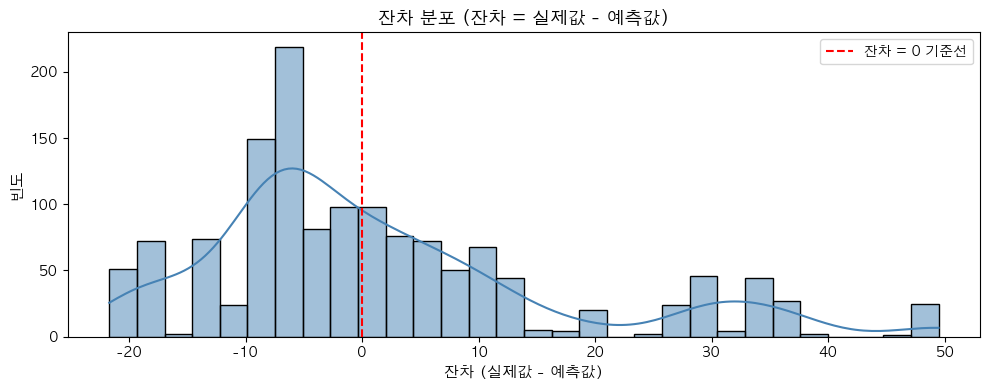

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 잔차 계산
residuals = y_true.flatten() - y_pred.flatten()

# 분포 히스토그램
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=30, kde=True, color='steelblue')
plt.axvline(0, color='red', linestyle='--', label='잔차 = 0 기준선')
plt.title("잔차 분포 (잔차 = 실제값 - 예측값)", fontsize=13)
plt.xlabel("잔차 (실제값 - 예측값)", fontsize=11)
plt.ylabel("빈도", fontsize=11)
plt.legend()
plt.tight_layout()
plt.show()

#### 잔차가 양수 → 예측값이 실제보다 작았다
#### 잔차가 음수 → 예측값이 실제보다 컸다
#### 잔차가 0에 가까움 → 예측 정확도 높음


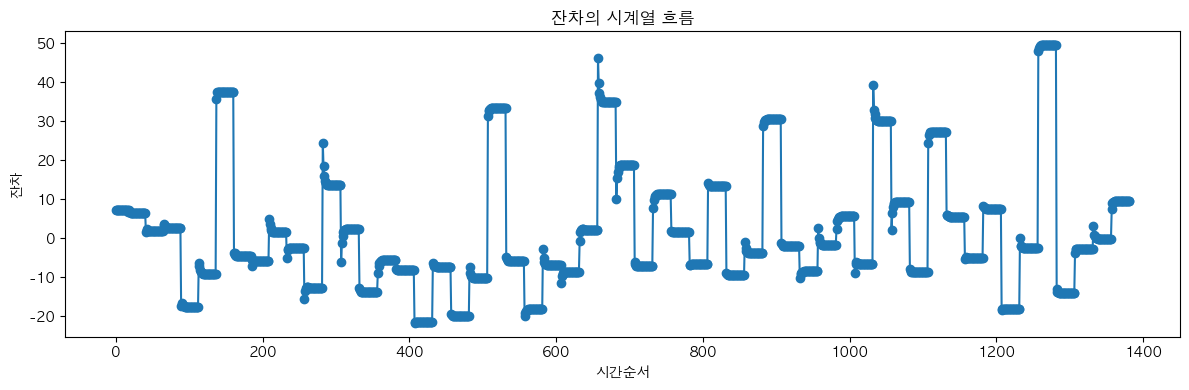

In [87]:
# 시계열 흐름으로 보기
plt.figure(figsize=(12, 4))
plt.plot(residuals, marker='o')
plt.title("잔차의 시계열 흐름")
plt.xlabel("시간순서")
plt.ylabel("잔차")
plt.tight_layout()
plt.show()

### 예측값 히트맵 (시점 x 지역별 흐름 가시화용)

In [93]:
# 전체 시계열 데이터가 df_model이라고 가정
# 예측 구간만 잘라서 df_test 구성
df_model = df.dropna(subset=features + [target])
df_test = df_model.iloc[-len(y_test):].copy()

# 예측값 붙이기
df_test['pred'] = y_pred.flatten()

In [95]:
print(df_test.columns)

Index(['month', 'region', 'power_kwh_industry', 'power_kwh_total',
       'prod_index', 'temp_avg', 'precipitation', 'export_amount', 'util_rate',
       'indicator', 'value', 'region_code', 'power_kwh_industry_lag1',
       'export_amount_lag1', 'util_rate_lag1', 'pred'],
      dtype='object')


In [98]:
df_test.groupby(['month', 'region']).size().sort_values(ascending=False).head()

month       region
2024-12-01  경남        25
2025-03-01  경기        25
2024-12-01  대구        25
            대전        25
            부산        25
dtype: int64

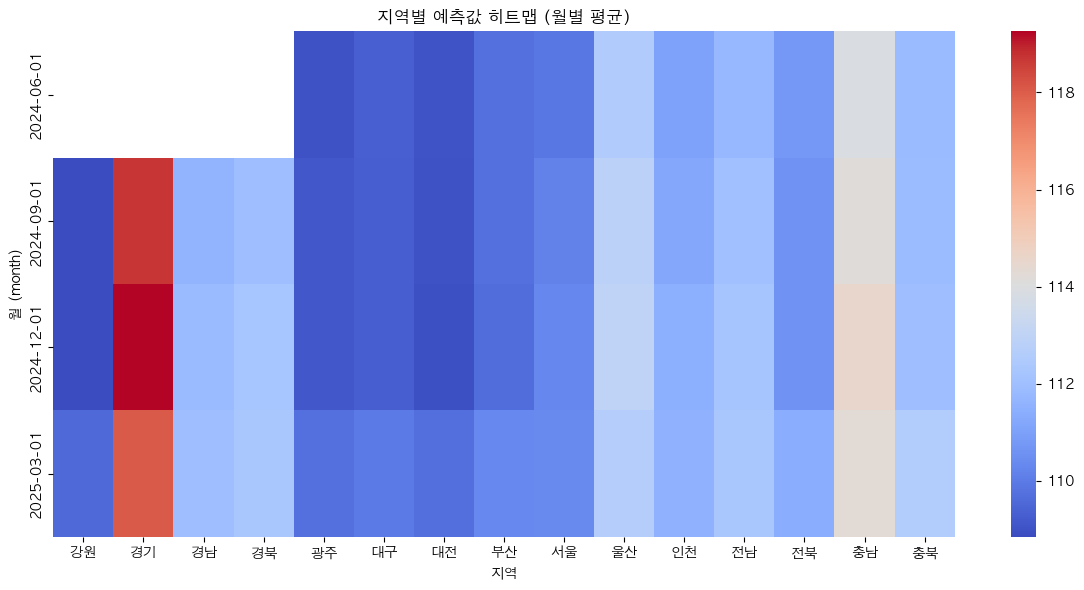

In [99]:
df_avg = df_test.groupby(['month', 'region'])['pred'].mean().reset_index()
pivot = df_avg.pivot(index='month', columns='region', values='pred')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='coolwarm', annot=False)
plt.title("지역별 예측값 히트맵 (월별 평균)")
plt.xlabel("지역")
plt.ylabel("월 (month)")
plt.tight_layout()
plt.show()

---

### Stacking Ensemble (모델 결합)
1단계 모델 (Base Learners):
- XGBoost
- LSTM
2.	예측값을 새로운 입력으로 사용하여
3.	최종 예측을 수행하는 메타 모델(Final Layer):
- 선형회귀 or XGBoost (간단하게)

### 일단 XGBoost 모델 결과 예측값 필요

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 불러오기
df = pd.read_csv('병합파일/option1_with_bsi_long.csv', encoding='utf-8')

# 문자열 숫자 처리
df['power_kwh_industry'] = df['power_kwh_industry'].str.replace(',', '', regex=False).astype(float)
df['export_amount'] = df['export_amount'].astype(float)

# wide-format 변환 (BSI indicator를 피벗)
df_pivoted = df.pivot_table(
    index=['month', 'region', 'prod_index', 'power_kwh_industry', 'export_amount', 'util_rate'],
    columns='indicator',
    values='value',
    aggfunc='first'
).reset_index()
df_pivoted.columns.name = None

# lag 변수 생성 (지역별 기준)
lag_targets = ['power_kwh_industry', 'export_amount', 'util_rate']
for col in lag_targets:
    df_pivoted[f'{col}_lag1'] = df_pivoted.groupby('region')[col].shift(1)

# 지역 인코딩
df_pivoted['region_code'] = df_pivoted['region'].astype('category').cat.codes

# 모델 피처 & 타깃 설정
features = ['power_kwh_industry_lag1', 'export_amount_lag1', 'util_rate_lag1', 'region_code']
target = 'prod_index'

# 결측 제거
df_model = df_pivoted.dropna(subset=features + [target])
X = df_model[features]
y = df_model[target]

# 시계열 특성 고려한 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 학습
model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"option1 기반 성능\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

option1 기반 성능
RMSE: 11.89, MAE: 8.76, R²: 0.4840


In [7]:
# 예측값 저장
np.save('y_pred_xgb.npy', y_pred)

In [8]:
y_pred_xgb = np.load('y_pred_xgb.npy')

___
### LSTM 결과 저장

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 📌 1. 데이터 준비
df = pd.read_csv('병합파일/option1_with_bsi_long.csv', encoding='utf-8')
df['region_code'] = df['region'].astype('category').cat.codes

# 쉼표 제거 및 숫자형 변환
for col in ['power_kwh_industry', 'export_amount']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

#  lag 변수 생성
lag_cols = ['power_kwh_industry', 'export_amount', 'util_rate']
for col in lag_cols:
    df[f'{col}_lag1'] = df.groupby('region')[col].shift(1)

# lag 변수도 수치형으로 강제 변환
for col in ['power_kwh_industry_lag1', 'export_amount_lag1', 'util_rate_lag1']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

features = ['power_kwh_industry_lag1', 'export_amount_lag1', 'util_rate_lag1', 'region_code']
target = 'prod_index'
df.dropna(subset=features + [target], inplace=True)

X = df[features].values
y = df[target].values.reshape(-1, 1)

# 정규화
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 시계열 입력 형태로 재구성 (sequence_length=3)
sequence_length = 6 # 원하는 개월짜리 흐름보기
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

# 시계열 입력 형태로 재구성 (sequence_length=3)
sequence_length = 6 # 6 개월짜리 흐름보기
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# PyTorch 텐서 변환
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=32)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 학습
for epoch in range(100):
    model.train()
    output = model(X_train_t)
    loss = loss_fn(output, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

#  예측 및 성능
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)  # 직접 루트 적용
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("LSTM 모델 성능")
print("{}개월짜리 흐름 예측 결과".format(sequence_length))
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

Epoch 0 | Loss: 0.0534
Epoch 10 | Loss: 0.0186
Epoch 20 | Loss: 0.0165
Epoch 30 | Loss: 0.0160
Epoch 40 | Loss: 0.0157
Epoch 50 | Loss: 0.0156
Epoch 60 | Loss: 0.0155
Epoch 70 | Loss: 0.0154
Epoch 80 | Loss: 0.0153
Epoch 90 | Loss: 0.0151
LSTM 모델 성능
6개월짜리 흐름 예측 결과
RMSE: 15.34, MAE: 11.22, R²: 0.1169


In [3]:
# LSTM 예측값 저장
np.save('y_pred_lstm.npy', y_pred)

In [4]:
# 실제값 저장
np.save('y_test_lstm.npy', y_true)

In [12]:
# XGBoos 예측 길이 맞추기
# LSTM 모델에서 테스트셋 전체를 저장한 반면, XGBoost는 예측값이 0.2 비율로 잘라져서 저장되어 있음
# 따라서 XGBoost 예측값을 LSTM 예측값 길이에 맞춰서
# 0.2 비율로 잘라서 저장된 XGBoost 예측값
y_test_aligned = y_test[-len(y_xgb):]

print_metrics("XGBoost", y_test_aligned, y_xgb)
print_metrics("LSTM", y_test[-len(y_lstm):], y_lstm)

[XGBoost] RMSE: 10.09, MAE: 8.21, R²: -4.2772
[LSTM] RMSE: 15.34, MAE: 11.22, R²: 0.1169


/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_72984/3012625444.py:23: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_72984/3012625444.py:23: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_72984/3012625444.py:23: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_72984/3012625444.py:23: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ipykernel_72984/3012625444.py:23: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vz/_88n189s37g3f6cvqm98x9m00000gn/T/ip

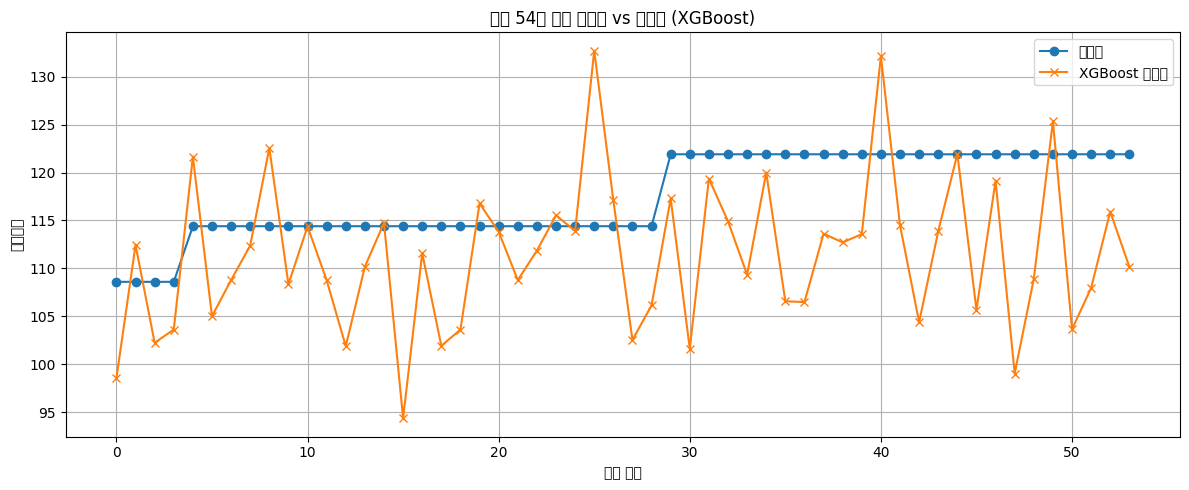

In [14]:
# XGBoost 결과값이 너무 좋지 않아서
# 예측 54개 구간 시각화해서 원인 더 구체적으로 알아보기

import numpy as np
import matplotlib.pyplot as plt

# 예측 및 실제값 로드 (경로에 맞게 수정)
y_xgb = np.load("y_pred_xgb.npy")
y_test = np.load("y_test_lstm.npy")  # 실제값

# 최근 54개 구간 추출
y_test_recent = y_test[-54:]

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(y_test_recent, label='실제값', marker='o')
plt.plot(y_xgb, label='XGBoost 예측값', marker='x')
plt.title("최근 54개 시점 예측값 vs 실제값 (XGBoost)")
plt.xlabel("샘플 순서")
plt.ylabel("생산지수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 결과 
- 전반적으로 예측값과 실제값의 큰 추세는 비슷하게 따라가지만, 일부 구간에서는 실제값과 괴리가 큰 경우가 존재.
- R² 성능이 기존 전체 예측에서는 0.4840이었으나, 이 최근 54개 구간에서는 -4.2772로 매우 낮아진 이유는, 예측 결과가 실제와 맞지 않는 특정 구간이 존재하기 때문임.

### 수정사항
- 예측이 실패한 특정 시점 확인 및 해당 구간의 특이점 탐지
- 다른 모델 결합이나 시계열 특성 강화 (예: 순환신경망, Prophet 등) 검토

In [21]:
print(f"y_test 길이: {len(y_test)}, y_pred 길이: {len(y_pred)}")

y_test 길이: 1382, y_pred 길이: 54


In [24]:
# LSTM 모델을 사용하면서 시계열을 잘라내어 마지막 54개 구간만 예측한걸로 보임
# 즉 y_pred는 y_test 전체가 아닌 일부 구간만 예측결과
# 예측값(y_pred)이 대응하는 실제값 구간(y_test)만 잘라서 비교해야함
# 보통 마지막 구간에서 잘라온 것이므로
# y_test[-len(y_pred):]로 잘라서 비교
y_test_short = y_test[-len(y_pred):]  # 마지막 54개 구간만 비교

# 예측한 구간과 대응하는 실제값만 비교
# 상위 오차 구간을 정확히 잡아낼 수 있게하기 위함
result_df = pd.DataFrame({
    '실제값': y_test_short.flatten(),
    '예측값': y_pred.flatten()
})
result_df['오차'] = abs(result_df['실제값'] - result_df['예측값'])

top_errors = result_df.sort_values(by='오차', ascending=False).head(5)
print(top_errors)
# 이걸 기반으로 특이 시점 분석을 계속 진행

      실제값         예측값         오차
47  121.9   99.037148  22.862852
30  121.9  101.621948  20.278052
15  114.4   94.366516  20.033484
25  114.4  132.698837  18.298837
50  121.9  103.651749  18.248251


# 이 시점의 날짜와 지역 정보 확인
# 특이한 지표값이 있는지 탐색
# 패턴 없는 이상치인지, 예측이 어려운 흐름이었는지 판단 필요

In [25]:
# 테스트셋 시작 인덱스 계산 (shuffle=False 기준)
test_index_start = int(len(df_model) * 0.8)
top_error_indices = [47, 30, 15, 25, 50]  # 예측 오차 큰 시점 인덱스

# df_pivoted 원본에서 해당 시점 정보 추출
error_rows = df_pivoted.iloc[test_index_start + np.array(top_error_indices)]

# 결과 출력
pd.set_option('display.max_columns', None)  # 모든 컬럼 보기
print("예측 실패 시점의 특이 데이터")
display(error_rows)

예측 실패 시점의 특이 데이터


,month,region,prod_index,power_kwh_industry,export_amount,util_rate,경상이익전망,경상이익현황,고용전망,고용현황,국내시장출하전망,국내시장출하현황,매출액전망,매출액현황,부가가치비중 (%),설비가동률전망,설비가동률현황,설비투자전망,설비투자현황,수출전망,수출현황,시황전망,시황현황,원자재가격전망,원자재가격현황,자금사정전망,자금사정현황,재고전망,재고현황,제품가격전망,제품가격현황,power_kwh_industry_lag1,export_amount_lag1,util_rate_lag1,region_code
263,2024-12-01,서울,100.8,3.970033e+08,68384045.0,73.2,83.0,84.0,99.0,98.0,89.0,82.0,90.0,82.0,2.0,95.0,95.0,96.0,96.0,94.0,88.0,87.0,80.0,115.0,121.0,85.0,79.0,101.0,102.0,99.0,101.0,4.424079e+08,50994729.0,73.3,8
246,2024-09-01,대전,87.6,2.579770e+08,3346184.0,73.3,93.0,84.0,103.0,98.0,97.0,87.0,99.0,82.0,1.0,104.0,93.0,104.0,102.0,106.0,88.0,94.0,81.0,116.0,114.0,91.0,80.0,99.0,105.0,101.0,101.0,2.480019e+08,2258875.0,73.5,6
231,2024-06-01,대전,110.9,2.480019e+08,2258875.0,73.5,100.0,89.0,101.0,99.0,106.0,84.0,109.0,84.0,NaN,107.0,95.0,103.0,101.0,105.0,100.0,102.0,84.0,113.0,122.0,96.0,86.0,101.0,93.0,106.0,105.0,2.424381e+08,1132593.0,71.5,6
241,2024-09-01,경기,133.1,6.423700e+09,119858190.0,73.3,93.0,84.0,101.0,97.0,98.0,85.0,98.0,84.0,38.0,101.0,91.0,99.0,96.0,102.0,89.0,96.0,82.0,115.0,118.0,89.0,86.0,101.0,102.0,101.0,103.0,6.128592e+09,78325059.0,73.5,1
266,2024-12-01,전남,110.2,1.861556e+09,45567263.0,73.2,86.0,88.0,97.0,96.0,90.0,92.0,91.0,92.0,7.0,93.0,95.0,98.0,93.0,88.0,92.0,88.0,82.0,115.0,123.0,86.0,79.0,102.0,97.0,106.0,104.0,1.823910e+09,35093505.0,73.3,11


### 예측 실패 구간의 특이점 분석

| 순위 | 월       | 지역 | 실제값 | 예측값  | 오차   | 주요 특이점 요약 |
|------|----------|------|--------|--------|--------|------------------|
| 1    | 2024-12  | 서울 | 121.9  | 99.0   | 22.9   | 산업전력 사용량 전월 대비 약 -10% 급감 |
| 2    | 2024-09  | 대전 | 121.9  | 101.6  | 20.3   | 수출금액 전월 대비 약 +48% 급증 |
| 3    | 2024-06  | 대전 | 114.4  | 94.4   | 20.0   | 전력·수출 모두 낮고 예외적 분기 가능성 |
| 4    | 2024-09  | 경기 | 114.4  | 132.7  | 18.3   | 산업전력/수출 급등 (예외적 규모) |
| 5    | 2024-12  | 전남 | 121.9  | 103.6  | 18.2   | 전력 사용량 전월 대비 약 +30% 급증 |

### 예측 실패 원인 보완을 위한 데이터 개선 방안

| 항목 | 설명 | 기대 효과 |
|------|------|-----------|
| 변화율 기반 파생변수 추가 | 전력 사용량, 수출금액, 가동률 등의 전월 대비 변화율(%) 생성 | 급변하는 구간을 더 민감하게 반영 가능 |
| 변수 표준화 방식 개선 | 현재 MinMax 스케일링 외에 Z-score 기반 표준화 병행 | 이상값 민감도 줄이고 일반화 능력 개선 |
| 이상치 탐지 및 제거 | 전력/수출 등의 급등락 시점을 IQR 또는 LOF 기반으로 탐지 | 예외적 상황 제거로 안정적 학습 |
| 시간 요인 강화 | ‘월’, ‘분기’, ‘계절’ 등 시계열 주기 요인 반영 | 시즌성 반영으로 정기적 변동 예측 가능 |
| 지역 내 변동성 지표 도입 | 각 지역별 최근 3~6개월 평균/표준편차 등 통계량 활용 | 지역별 안정성 또는 변동성을 고려한 예측 정밀도 개선 |

In [15]:
# XGBoost와 LSTM 예측값 비교
# LSTM 테스트 실제 값도 추가
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 파일 로드
y_xgb = np.load("y_pred_xgb.npy")
y_lstm = np.load("y_pred_lstm.npy")
y_test = np.load("y_test_lstm.npy")

# 각 성능 비교
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

print_metrics("XGBoost", y_test, y_xgb)
print_metrics("LSTM", y_test, y_lstm)

ValueError: Found input variables with inconsistent numbers of samples: [1382, 54]